# Telecom Churn Prediction - Assignment Notebook

**Author:** Michael Thomas & Supriyo Roy

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [307]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [308]:
# #INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
# #(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv", index_col=None)
unseen = pd.read_csv("test.csv", index_col=None)
sample = pd.read_csv("sample.csv", index_col=None)
data_dict = pd.read_csv("data_dictionary.csv", index_col=None)


print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [309]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

# 2. Create X, y, Derive New Columns and then Train test split

Lets create X and y datasets and drop any column with only 1 unique value

### 2.1 Create X, y

In [310]:
data['circle_id'].unique()

array([109])

In [311]:
print(unseen.columns)


Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=171)


In [312]:
X.head()

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  monthly_3g_8  sachet_3g_6  \
0         32.24         96.68          2.33  ...             0            0   
1          0.00         25.99         30.89  ...             0            0   
2         53.99         82.05          0.00  ...             0            0   
3         68.76         78.48         50.23  ...             0            0   
4         56.99         38.11          9.63  ...             0            0   

   sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8   aon  \
0            0            0        NaN        NaN        NaN  1958   
1            0            0        NaN        1.0        NaN   710   
2            0            0        NaN        NaN        NaN   882   
3            0            0        NaN        NaN        NaN   982   
4            1            0        1.0        1.0        1.0   647   

   aug_vbc_3g  jul_vbc_3g  
0         0.0         0.0  
1         0.0         0.0  
2         0.0         0.0  
3         0.0         0.0  
4         0.0         0.0  

[5 rows x 151 columns]

In [313]:
X = data.drop(['circle_id'], axis='columns').iloc[:, :-1]
unseen = unseen.drop(['circle_id'], axis=1, errors='ignore')
y = data.iloc[:, -1]

X.shape, y.shape, unseen.shape


((69999, 170), (69999,), (30000, 170))

In [314]:
print(y)

0        0
1        0
2        0
3        0
4        0
        ..
69994    0
69995    0
69996    0
69997    0
69998    0
Name: churn_probability, Length: 69999, dtype: int64


In [315]:
print(X.columns)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g'],
      dtype='object', length=170)


In [316]:
X.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0   0             0.0             0.0             0.0            6/30/2014   
1   1             0.0             0.0             0.0            6/30/2014   
2   2             0.0             0.0             0.0            6/30/2014   
3   3             0.0             0.0             0.0            6/30/2014   
4   4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  ...  \
0            7/31/2014            8/31/2014   31.277   87.009    7.527  ...   
1            7/31/2014            8/31/2014    0.000  122.787   42.953  ...   
2            7/31/2014            8/31/2014   60.806  103.176    0.000  ...   
3            7/31/2014            8/31/2014  156.362  205.260  111.095  ...   
4            7/31/2014            8/31/2014  240.708  128.191  101.565  ...   

   sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0            0            0            0        NaN        NaN        NaN   
1            0            0            0        NaN        1.0        NaN   
2            0            0            0        NaN        NaN        NaN   
3            0            0            0        NaN        NaN        NaN   
4            0            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0  1958         0.0         0.0         0.0  
1   710         0.0         0.0         0.0  
2   882         0.0         0.0         0.0  
3   982         0.0         0.0         0.0  
4   647         0.0         0.0         0.0  

[5 rows x 170 columns]

### Removing columns - which have little/ no variation


In [317]:
# Dropping date columns, which don't appear to contribute to the results and are not numerical variables
columns_to_drop = [
    'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
    'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
    'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
]

# Drop the specified columns from `data`
X = X.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
unseen = unseen.drop(columns=columns_to_drop, axis='columns').iloc[:, :-1]
y = data.iloc[:, -1]

X.shape, y.shape, unseen.shape


((69999, 160), (69999,), (30000, 160))

In [318]:
# Dropping columns that only have a single value, and does not contribute to the results
threshold = 1

# Find columns with unique value counts below the threshold
few_unique_cols = {col: X[col].nunique() for col in X.columns if X[col].nunique() <= threshold}

# Display the columns and their unique counts
print(few_unique_cols)



{'loc_og_t2o_mou': 1, 'std_og_t2o_mou': 1, 'loc_ic_t2o_mou': 1, 'std_og_t2c_mou_6': 1, 'std_og_t2c_mou_7': 1, 'std_og_t2c_mou_8': 1, 'std_ic_t2o_mou_6': 1, 'std_ic_t2o_mou_7': 1, 'std_ic_t2o_mou_8': 1}


In [319]:
# Filter out columns with only one unique value
single_value_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these columns from the DataFrame
X = X.drop(columns=single_value_columns)
unseen = unseen.drop(columns=single_value_columns)

# Display the shape of the updated DataFrame to confirm columns were dropped
X.shape, y.shape, unseen.shape


((69999, 151), (69999,), (30000, 151))

### Removing columns with more than 40% of missing data

<Axes: >

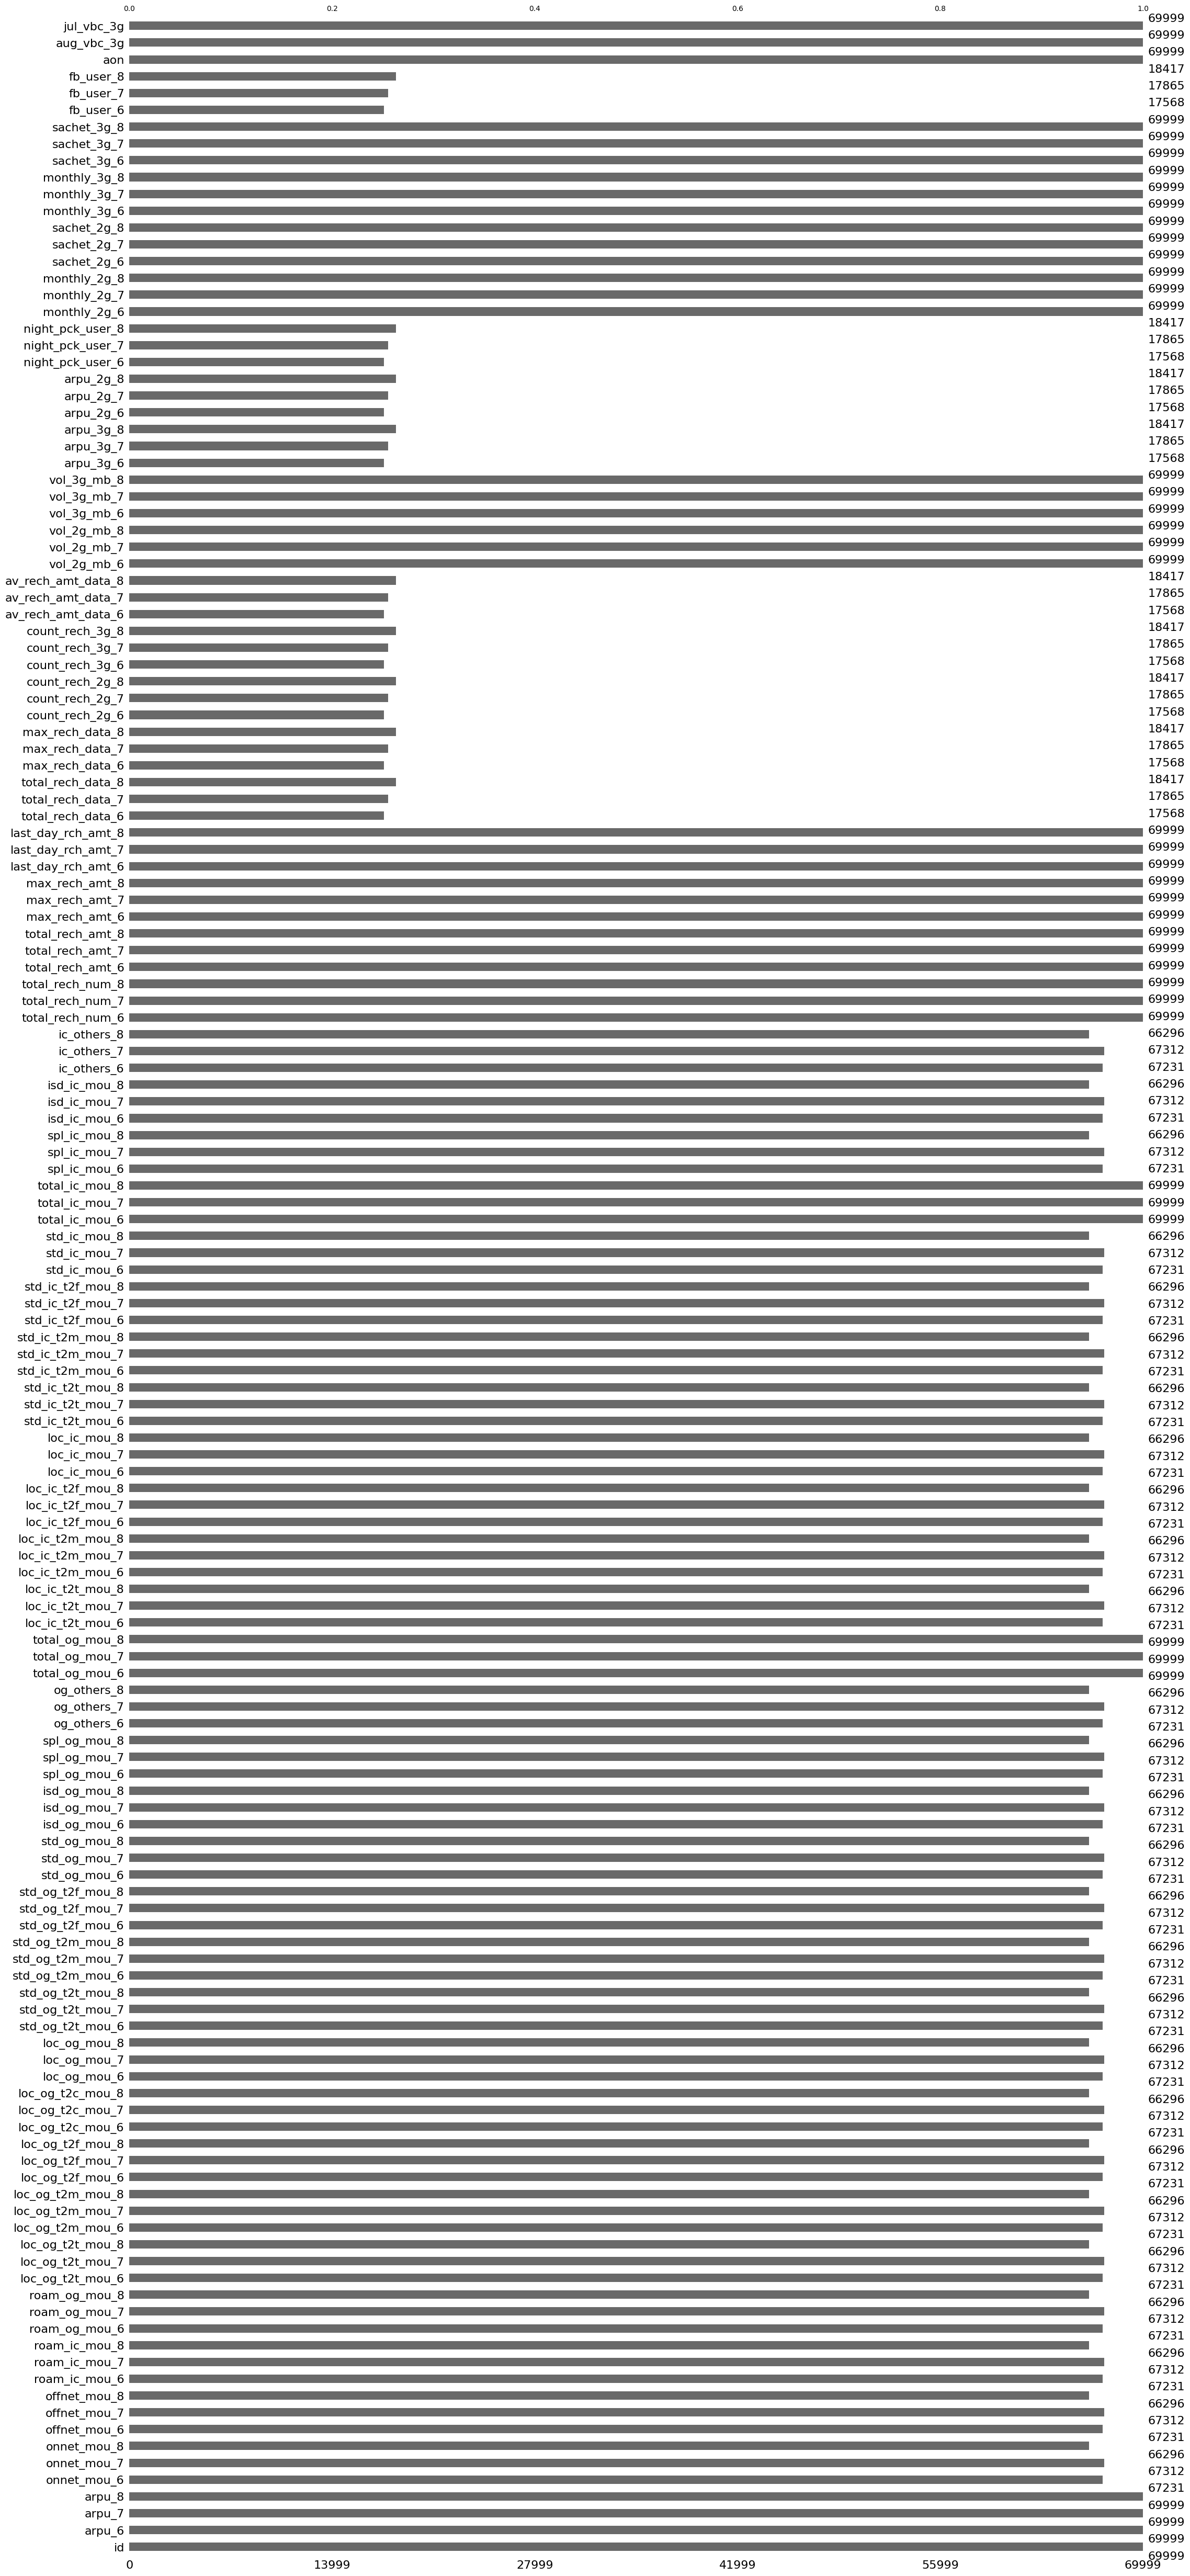

In [320]:
msno.bar(X)

In [321]:
missing_data_percent = 100*X.isnull().sum()/len(X)
missing_data_percent

id              0.000000
arpu_6          0.000000
arpu_7          0.000000
arpu_8          0.000000
onnet_mou_6     3.954342
                 ...    
fb_user_7      74.478207
fb_user_8      73.689624
aon             0.000000
aug_vbc_3g      0.000000
jul_vbc_3g      0.000000
Length: 151, dtype: float64

In [322]:
# Identifying columns with less than 40% missing data
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       ...
       'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
       'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g'],
      dtype='object', length=124)

In [323]:
# We will work only with columns that have less than 40% missing data
X_filtered = X[new_vars]
unseen_filtered = unseen[new_vars]


In [324]:
X_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  69999.000000  69999.000000  69999.000000  69999.000000  67231.000000   
mean   34999.000000    283.134365    278.185912    278.858826    133.153275   
std    20207.115084    334.213918    344.366927    351.924315    299.963093   
min        0.000000  -2258.709000  -1289.715000   -945.808000      0.000000   
25%    17499.500000     93.581000     86.714000     84.095000      7.410000   
50%    34999.000000    197.484000    191.588000    192.234000     34.110000   
75%    52498.500000    370.791000    365.369500    369.909000    119.390000   
max    69998.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  67312.000000  66296.000000  67231.000000  67312.000000  66296.000000   
mean     133.894438    132.978257    198.874771    197.153383    196.543577   
std      311.277193    311.896596    316.818355    322.482226    324.089234   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.675000      6.410000     34.860000     32.240000     31.575000   
50%       32.280000     32.100000     96.480000     91.885000     91.800000   
75%      115.837500    115.060000    232.990000    227.630000    229.345000   
max     8157.780000  10752.560000   8362.360000   7043.980000  14007.340000   

       ...   sachet_2g_8  monthly_3g_6  monthly_3g_7  monthly_3g_8  \
count  ...  69999.000000  69999.000000  69999.000000  69999.000000   
mean   ...      0.449492      0.075815      0.077730      0.081958   
std    ...      1.632450      0.358905      0.383189      0.381821   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...     44.000000      9.000000     16.000000     16.000000   

        sachet_3g_6   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  69999.000000  69999.000000  69999.000000  69999.000000  69999.000000   
mean       0.075344      0.081444      0.085487   1220.639709     68.108597   
std        0.573003      0.634547      0.680035    952.426321    269.328659   
min        0.000000      0.000000      0.000000    180.000000      0.000000   
25%        0.000000      0.000000      0.000000    468.000000      0.000000   
50%        0.000000      0.000000      0.000000    868.000000      0.000000   
75%        0.000000      0.000000      0.000000   1813.000000      0.000000   
max       29.000000     33.000000     41.000000   4337.000000  12916.220000   

         jul_vbc_3g  
count  69999.000000  
mean      65.935830  
std      267.899034  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max     9165.600000  

[8 rows x 124 columns]

In [325]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of unseen_filtered: {unseen_filtered.shape}")

print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 124)
Shape of unseen_filtered: (30000, 124)
Shape of y: (69999,)


## 2.2 Deriving New Feature Columns 

We noticed that while there are a series of colulmns related to the same type of variable, there is no variable which explains the percentage increase or decrese over that time period. Consequently we are proposing to add a few new columns for 

- Average change in revenue per user across months 6,7,8 (arpu_6, arpu_7, arpu_8)
- Average change in all kinds of calls within the same operator network for months 6,7,8 (onnet_mou_6, onnet_mou_7, onnet_mou_8)
- Average change in all kinds of calls outside the same operator network for months 6,7,8 (offnet_mou_6, offnet_mou_7, offnet_mou_8)




### Deriving new columns for average changes in revenue across months 6,7,8 (arpu_6, arpu_7, arpu_8)
Calculate the change in revenue between months:

From month 6 to month 7 (arpu_7 - arpu_6)
From month 7 to month 8 (arpu_8 - arpu_7)
Take the average of these two changes to create a new derived col


In [326]:
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 124)
Shape of y: (69999,)


In [327]:
# Calculate the average absolute change in revenue
X_filtered['avg_absolute_change_revenue'] = (
    (X_filtered['arpu_7'] - X_filtered['arpu_6']) +
    (X_filtered['arpu_8'] - X_filtered['arpu_7'])
) / 2

# Calculate the average percentage change in revenue
X_filtered['avg_percentage_change_revenue'] = (
    ((X_filtered['arpu_7'] - X_filtered['arpu_6']) / X_filtered['arpu_6']) +
    ((X_filtered['arpu_8'] - X_filtered['arpu_7']) / X_filtered['arpu_7'])
) / 2


In [328]:
# Calculate the average absolute change in revenue for unseen
unseen_filtered['avg_absolute_change_revenue'] = (
    (X_filtered['arpu_7'] - X_filtered['arpu_6']) +
    (X_filtered['arpu_8'] - X_filtered['arpu_7'])
) / 2

# Calculate the average percentage change in revenue
unseen_filtered['avg_percentage_change_revenue'] = (
    ((X_filtered['arpu_7'] - X_filtered['arpu_6']) / X_filtered['arpu_6']) +
    ((X_filtered['arpu_8'] - X_filtered['arpu_7']) / X_filtered['arpu_7'])
) / 2

In [329]:
X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe()


avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf

In [330]:
# Confirming that the number of columns have increased from 125 to 127
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of unseen_filtered: {unseen_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 126)
Shape of unseen_filtered: (30000, 126)
Shape of y: (69999,)


In [331]:
# Compute the mean and describe
print(X_filtered['avg_percentage_change_revenue'].mean())
print(X_filtered[['avg_absolute_change_revenue', 'avg_percentage_change_revenue']].describe())


nan
       avg_absolute_change_revenue  avg_percentage_change_revenue
count                 69999.000000                   6.837700e+04
mean                     -2.137769                            NaN
std                     145.127104                            NaN
min                   -5752.754000                           -inf
25%                     -51.805750                  -1.427237e-01
50%                      -0.732000                   9.301916e-02
75%                      47.756250                   5.329413e-01
max                    6804.332000                            inf


In [332]:
# Replace infinity with NaN
X_filtered['avg_percentage_change_revenue'] = X_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = X_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
X_filtered['avg_percentage_change_revenue'] = X_filtered['avg_percentage_change_revenue'].fillna(median_value)


In [333]:
# Replace infinity with NaN for unseen data
unseen_filtered['avg_percentage_change_revenue'] = unseen_filtered['avg_percentage_change_revenue'].replace([np.inf, -np.inf], np.nan)

# Calculate the median of the column
median_value = unseen_filtered['avg_percentage_change_revenue'].median()

# Replace NaN with the median value
unseen_filtered['avg_percentage_change_revenue'] = X_filtered['avg_percentage_change_revenue'].fillna(median_value)

### Deriving a new column for average change in all kinds of calls within the same operator network 

In [334]:
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].describe()

onnet_mou_6   onnet_mou_7   onnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     133.153275    133.894438    132.978257
std      299.963093    311.277193    311.896596
min        0.000000      0.000000      0.000000
25%        7.410000      6.675000      6.410000
50%       34.110000     32.280000     32.100000
75%      119.390000    115.837500    115.060000
max     7376.710000   8157.780000  10752.560000

In [335]:
# Replace missing values with 0 or any other appropriate default
X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']] = \
    X_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].fillna(0)


In [336]:
# Replace missing values with 0 or any other appropriate default for unseen data
unseen_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']] = \
    unseen_filtered[['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']].fillna(0)

In [337]:
# Calculate the average change in on-net minutes of usage
X_filtered['avg_change_onnet_mou'] = (
    (X_filtered['onnet_mou_7'] - X_filtered['onnet_mou_6']) +
    (X_filtered['onnet_mou_8'] - X_filtered['onnet_mou_7'])
) / 2


In [338]:
# Calculate the average change in on-net minutes of usage for unseen data
unseen_filtered['avg_change_onnet_mou'] = (
    (unseen_filtered['onnet_mou_7'] - unseen_filtered['onnet_mou_6']) +
    (unseen_filtered['onnet_mou_8'] - unseen_filtered['onnet_mou_7'])
) / 2


In [339]:
print(X_filtered['avg_change_onnet_mou'].describe())


count    69999.000000
mean        -0.972166
std        134.971400
min      -3411.600000
25%        -12.680000
50%          0.000000
75%         10.235000
max       3395.190000
Name: avg_change_onnet_mou, dtype: float64


In [340]:
# Testing that the columns have increased from 127 to 128
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of unseen_filtered: {unseen_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 127)
Shape of unseen_filtered: (30000, 127)
Shape of y: (69999,)


### Deriving a new column for average change in all kinds of calls outside the operator network 

In [343]:
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].describe()

offnet_mou_6  offnet_mou_7  offnet_mou_8
count  67231.000000  67312.000000  66296.000000
mean     198.874771    197.153383    196.543577
std      316.818355    322.482226    324.089234
min        0.000000      0.000000      0.000000
25%       34.860000     32.240000     31.575000
50%       96.480000     91.885000     91.800000
75%      232.990000    227.630000    229.345000
max     8362.360000   7043.980000  14007.340000

In [344]:
# Calculate the average change in off-net minutes of usage
X_filtered['avg_change_offnet_mou'] = (
    (X_filtered['offnet_mou_7'] - X_filtered['offnet_mou_6']) +
    (X_filtered['offnet_mou_8'] - X_filtered['offnet_mou_7'])
) / 2


In [345]:
# Calculate the average change in off-net minutes of usage for unseen data
unseen_filtered['avg_change_offnet_mou'] = (
    (unseen_filtered['offnet_mou_7'] - unseen_filtered['offnet_mou_6']) +
    (unseen_filtered['offnet_mou_8'] - unseen_filtered['offnet_mou_7'])
) / 2

In [346]:
# Replace missing values with 0 or another appropriate value
X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']] = \
    X_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].fillna(0)


In [347]:
# Replace missing values with 0 or another appropriate value
unseen_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']] = \
    unseen_filtered[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']].fillna(0)

In [348]:
print(X_filtered['avg_change_offnet_mou'].describe())


count    63842.000000
mean        -1.165819
std        141.760274
min      -4166.000000
25%        -27.360000
50%         -0.520000
75%         23.388750
max       6887.525000
Name: avg_change_offnet_mou, dtype: float64


In [349]:
# Testing that the number of columns have increased from 128 to 129
print(f"Shape of X_filtered: {X_filtered.shape}")
print(f"Shape of unseen_filtered: {unseen_filtered.shape}")
print(f"Shape of y: {y.shape}")


Shape of X_filtered: (69999, 128)
Shape of unseen_filtered: (30000, 128)
Shape of y: (69999,)


## 2.3 Train Test Split

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, unseen_filtered.shape


((55999, 128), (14000, 128), (55999,), (14000,), (30000, 128))

In [351]:
X_train.head()

id   arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
19615  19615  287.801   290.261   191.137        69.09        85.96   
5083    5083  647.859  1641.555  1397.946      1105.33      3466.56   
9411    9411   10.130     0.000   261.281         0.00         0.00   
44946  44946  313.487   319.496   353.706        14.91         4.71   
54857  54857  367.672   440.740   445.746       169.79       419.98   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
19615        41.66        196.54        198.93        100.21  ...   
5083       3337.49        297.86        723.71        522.58  ...   
9411        199.24          1.08          0.00        168.09  ...   
44946        11.21         39.99         75.29        137.13  ...   
54857       222.78        182.79        156.01        414.58  ...   

       sachet_3g_6  sachet_3g_7  sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  \
19615            0            0            0  1432        0.00        0.00   
5083             0            0            0  1243        0.00        0.00   
9411             0            0            0   515       65.09        0.00   
44946            0            0            0  1025      466.10      292.67   
54857            0            0            0   298        0.00        0.00   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
19615                     -48.3320                      -0.166476   
5083                      375.0435                       0.692707   
9411                      125.5755                       0.072072   
44946                      20.1095                       0.063122   
54857                      39.0370                       0.105045   

       avg_change_onnet_mou  avg_change_offnet_mou  
19615               -13.715                -48.165  
5083               1116.080                112.360  
9411                 99.620                 83.505  
44946                -1.850                 48.570  
54857                26.495                115.895  

[5 rows x 128 columns]

# 3. Handling Missing data

## 3.1 Handling Missing data - Training Set

In [356]:
print(X_train.shape)
print(unseen_filtered.shape)
print(y_train.shape)


(55999, 128)
(30000, 128)
(55999,)


In [357]:
# Display the data types of each column
print(X_train.dtypes)


id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jul_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 128, dtype: object


In [358]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_train.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [355]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_train_filtered = X_train.apply(pd.to_numeric, errors='coerce')
unseen_filtered = unseen_filtered.apply(pd.to_numeric, errors='coerce')

In [359]:
print(X_train_filtered.shape)
print(unseen_filtered.shape)

print(y_train.shape)


(55999, 128)
(30000, 128)
(55999,)


<Axes: >

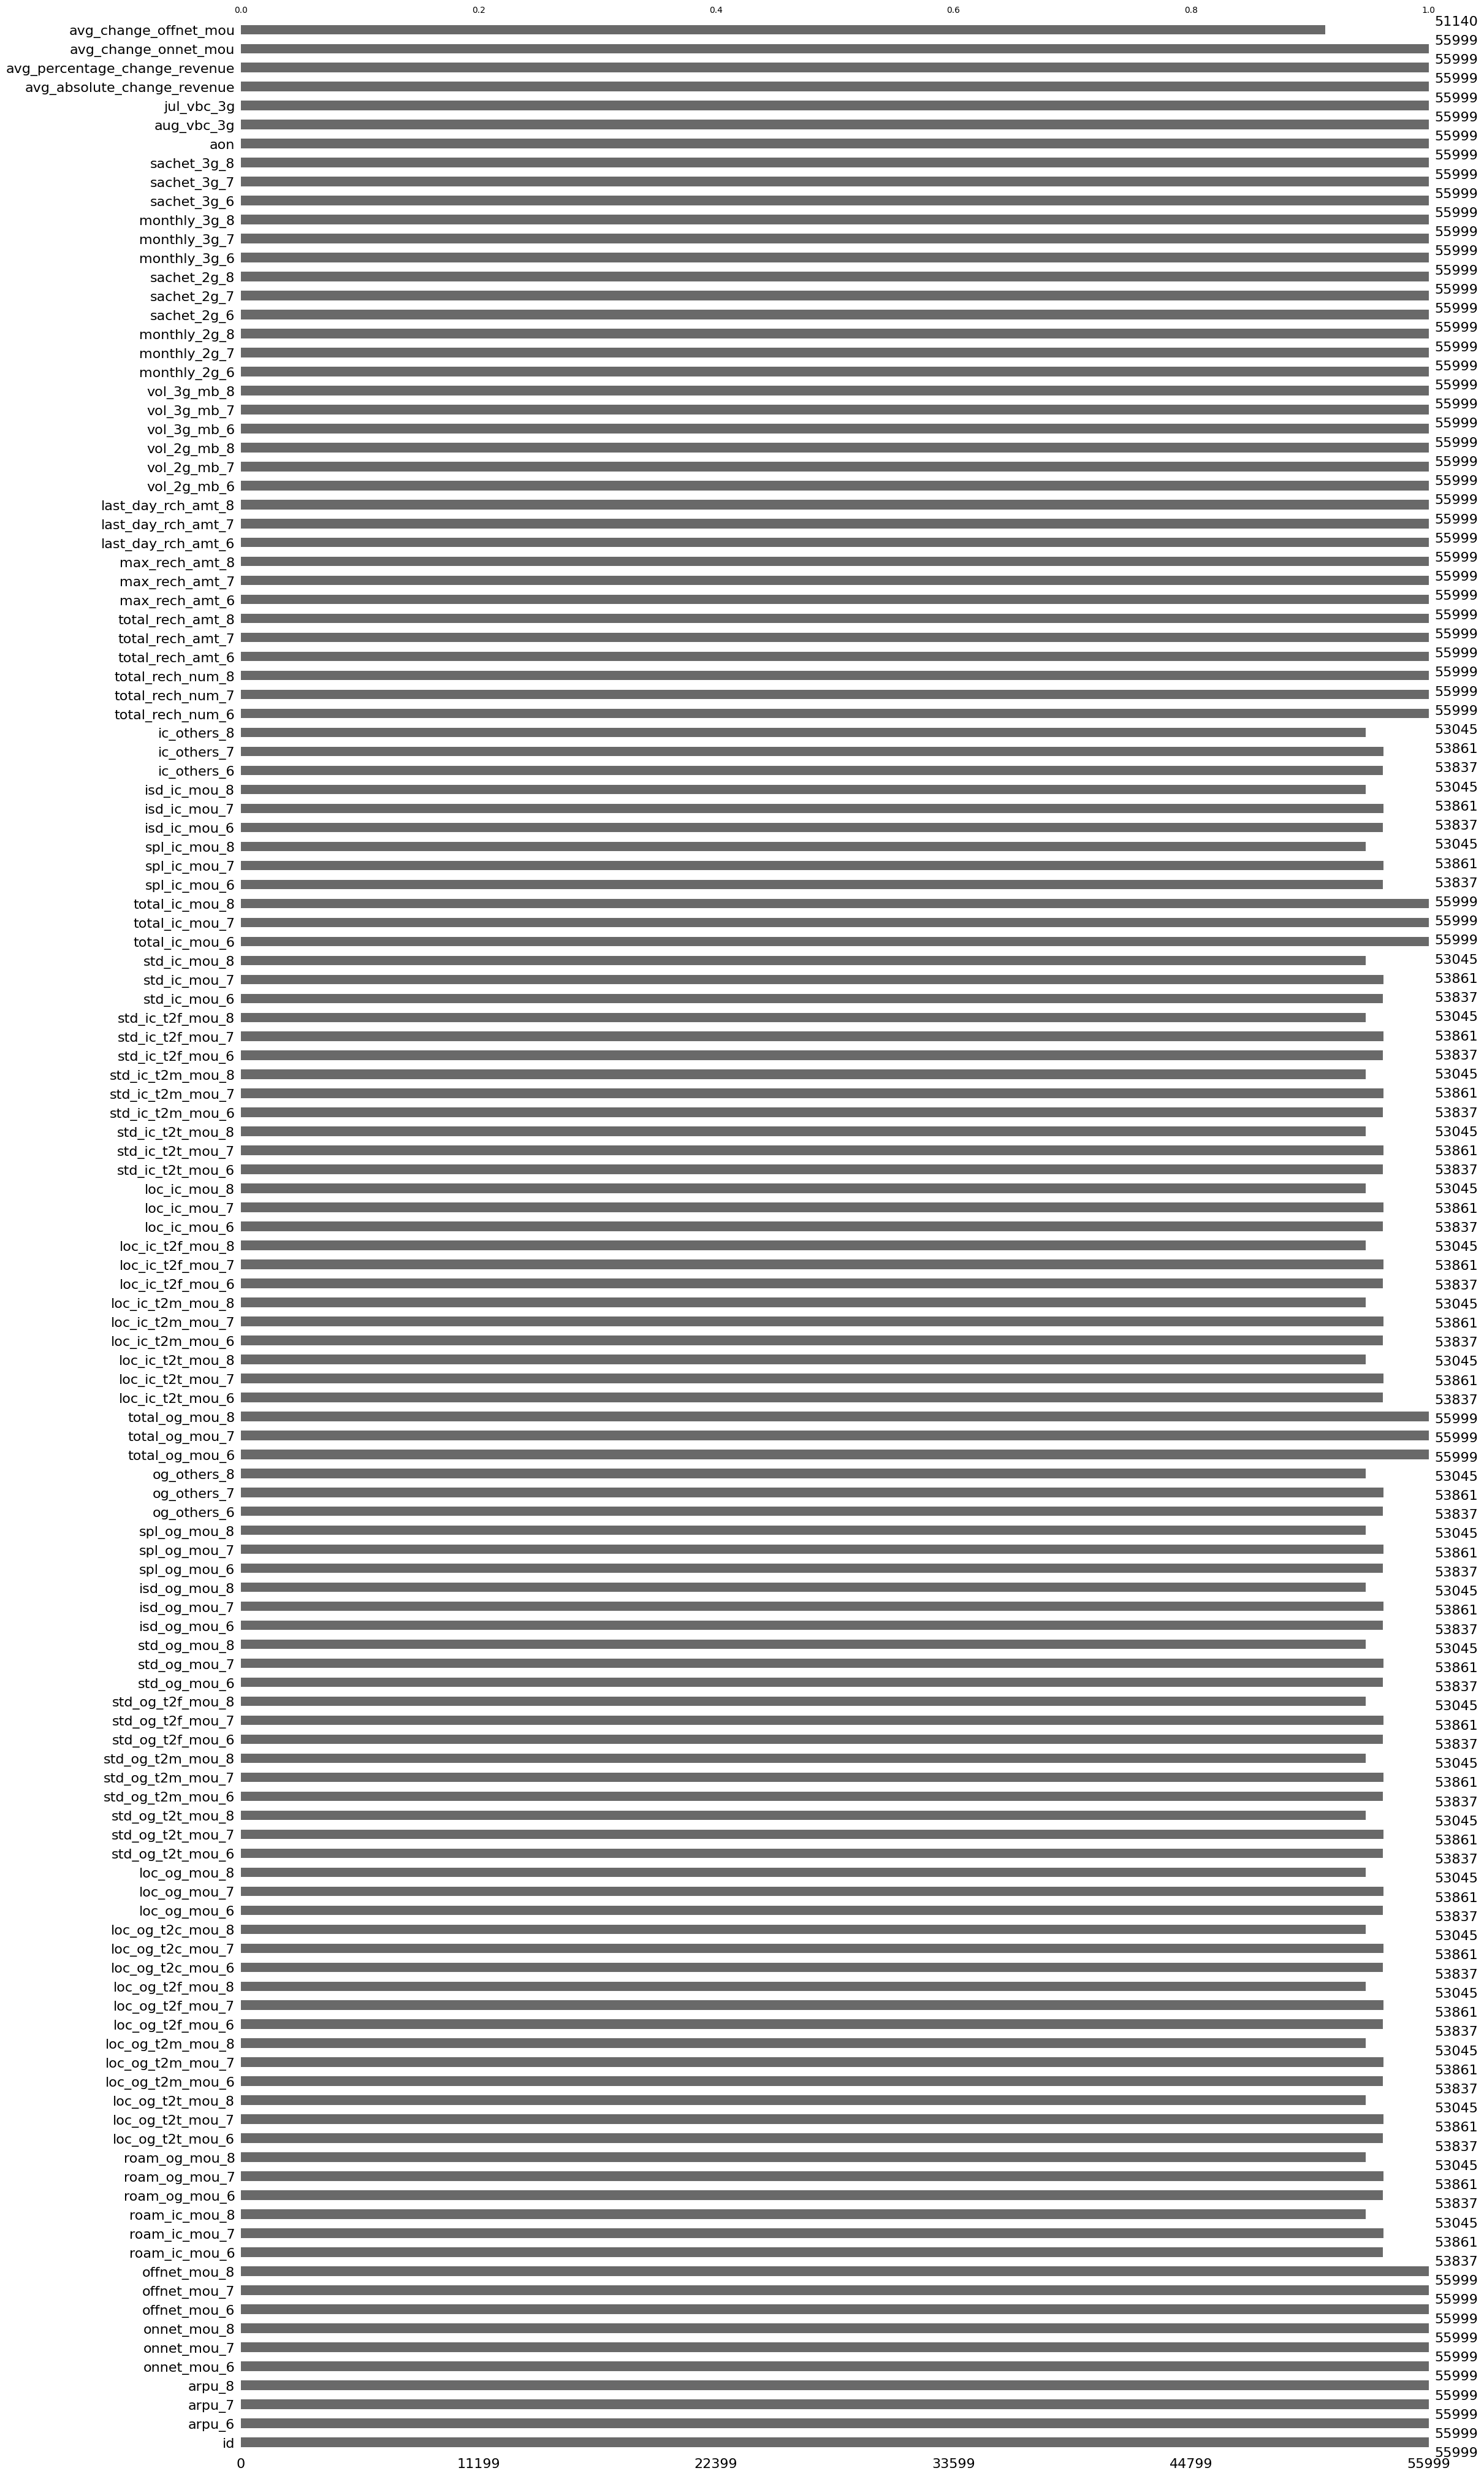

In [360]:
msno.bar(X_train)

In [361]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [362]:
# Check for infinite values
print(np.isinf(X_train_filtered).sum())

# Check for very large values
print((X_train_filtered.abs() > 1e308).sum())


id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jul_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 128, dtype: int64
id                               0
arpu_6                           0
arpu_7                           0
arpu_8                           0
onnet_mou_6                      0
                                ..
jul_vbc_3g                       0
avg_absolute_change_revenue      0
avg_percentage_change_revenue    0
avg_change_onnet_mou             0
avg_change_offnet_mou            0
Length: 128, dtype: int64


In [363]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])
unseen_filtered[impute_cols] = imp.fit_transform(unseen_filtered[impute_cols])

<Axes: >

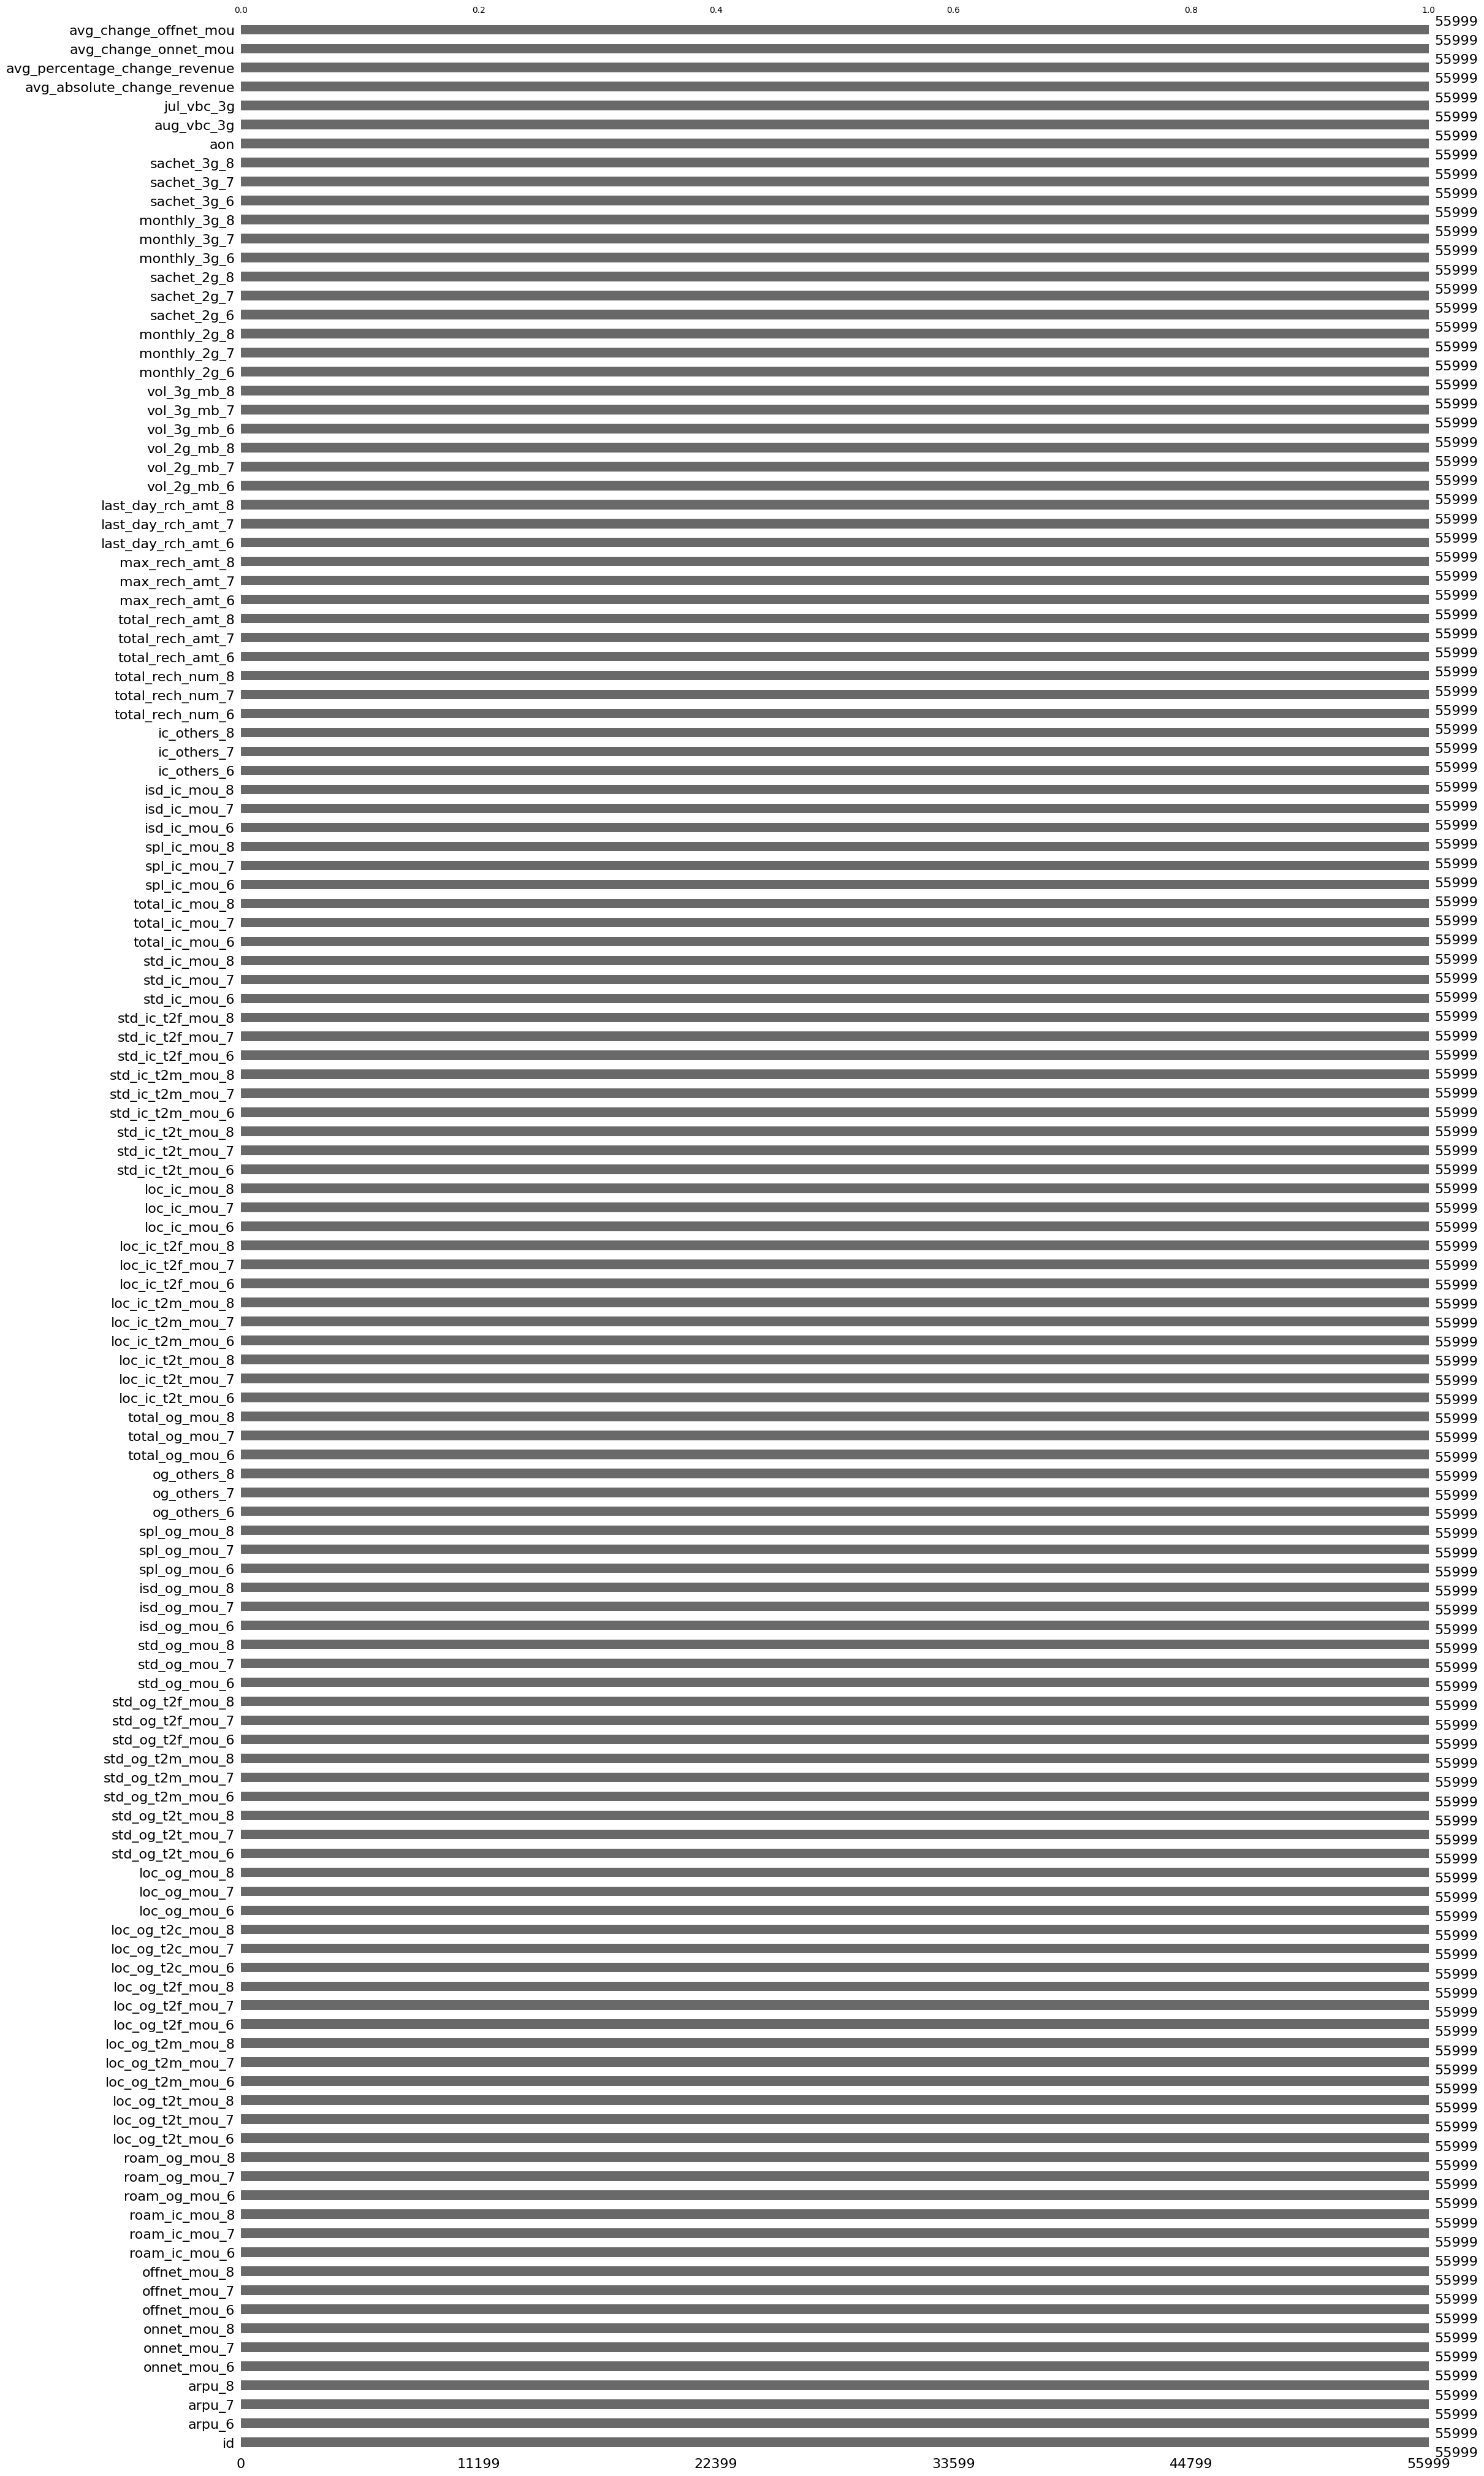

In [364]:
# Visually inspecting columns to ensure that missing values are filled
msno.bar(X_train_filtered)

In [365]:
# Checking consistency in the dimensions of X_train_filtered and y_train
print(X_train_filtered.shape)
print(unseen_filtered.shape)
print(y_train.shape)


(55999, 128)
(30000, 128)
(55999,)


In [366]:
X_train_filtered.describe()


id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean   34989.724067    282.633747    278.034719    278.637849    127.579784   
std    20199.680034    320.698835    322.861868    323.679687    295.654772   
min        0.000000  -2041.228000  -1289.715000   -945.808000      0.000000   
25%    17525.500000     93.746500     86.997000     84.098500      5.480000   
50%    34961.000000    197.149000    191.356000    192.799000     30.760000   
75%    52478.500000    370.341000    365.201000    370.336500    112.560000   
max    69998.000000  15487.684000  16820.145000  16040.503000   7011.110000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     129.396701    126.495068    190.416719    189.362613    186.499055   
std      310.310584    306.330787    311.299721    318.846903    319.907736   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.960000      4.140000     28.860000     26.730000     23.810000   
50%       29.060000     27.730000     89.590000     85.460000     82.740000   
75%      108.120000    106.210000    223.260000    218.425000    216.190000   
max     8157.780000  10752.560000   6712.810000   7043.980000  14007.340000   

       ...   sachet_3g_6   sachet_3g_7   sachet_3g_8           aon  \
count  ...  55999.000000  55999.000000  55999.000000  55999.000000   
mean   ...      0.077162      0.082394      0.085037   1221.483991   
std    ...      0.582578      0.633001      0.673211    952.947470   
min    ...      0.000000      0.000000      0.000000    180.000000   
25%    ...      0.000000      0.000000      0.000000    468.000000   
50%    ...      0.000000      0.000000      0.000000    868.000000   
75%    ...      0.000000      0.000000      0.000000   1813.000000   
max    ...     29.000000     33.000000     38.000000   4337.000000   

         aug_vbc_3g    jul_vbc_3g  avg_absolute_change_revenue  \
count  55999.000000  55999.000000                 55999.000000   
mean      67.331924     66.116797                    -1.997949   
std      265.961729    270.058579                   141.998928   
min        0.000000      0.000000                 -5752.754000   
25%        0.000000      0.000000                   -51.555000   
50%        0.000000      0.000000                    -0.615000   
75%        0.000000      0.000000                    47.596250   
max    12916.220000   9165.600000                  2844.561000   

       avg_percentage_change_revenue  avg_change_onnet_mou  \
count                   55999.000000          55999.000000   
mean                       11.236815             -0.542358   
std                       315.122146            135.127433   
min                     -7037.778051          -3411.600000   
25%                        -0.134235            -12.615000   
50%                         0.072072              0.000000   
75%                         0.385182             10.150000   
max                     28763.900009           3383.840000   

       avg_change_offnet_mou  
count           55999.000000  
mean               -0.668436  
std               133.547487  
min             -2236.875000  
25%               -23.242500  
50%                 0.000000  
75%                19.395000  
max              6887.525000  

[8 rows x 128 columns]

## 3.2 Handling Missing data - Test Set

In [367]:
# Display the data types of each column
print(X_test.dtypes)

id                                 int64
arpu_6                           float64
arpu_7                           float64
arpu_8                           float64
onnet_mou_6                      float64
                                  ...   
jul_vbc_3g                       float64
avg_absolute_change_revenue      float64
avg_percentage_change_revenue    float64
avg_change_onnet_mou             float64
avg_change_offnet_mou            float64
Length: 128, dtype: object


In [368]:
# Select and print the data types of non-numeric columns
non_numeric_dtypes = X_test.select_dtypes(exclude=[np.number]).dtypes
print(non_numeric_dtypes)


Series([], dtype: object)


In [369]:
# Convert all columns to numeric, setting non-numeric values to NaN
X_test_filtered = X_test.apply(pd.to_numeric, errors='coerce')
unseen_filtered = X_test.apply(pd.to_numeric, errors='coerce')

<Axes: >

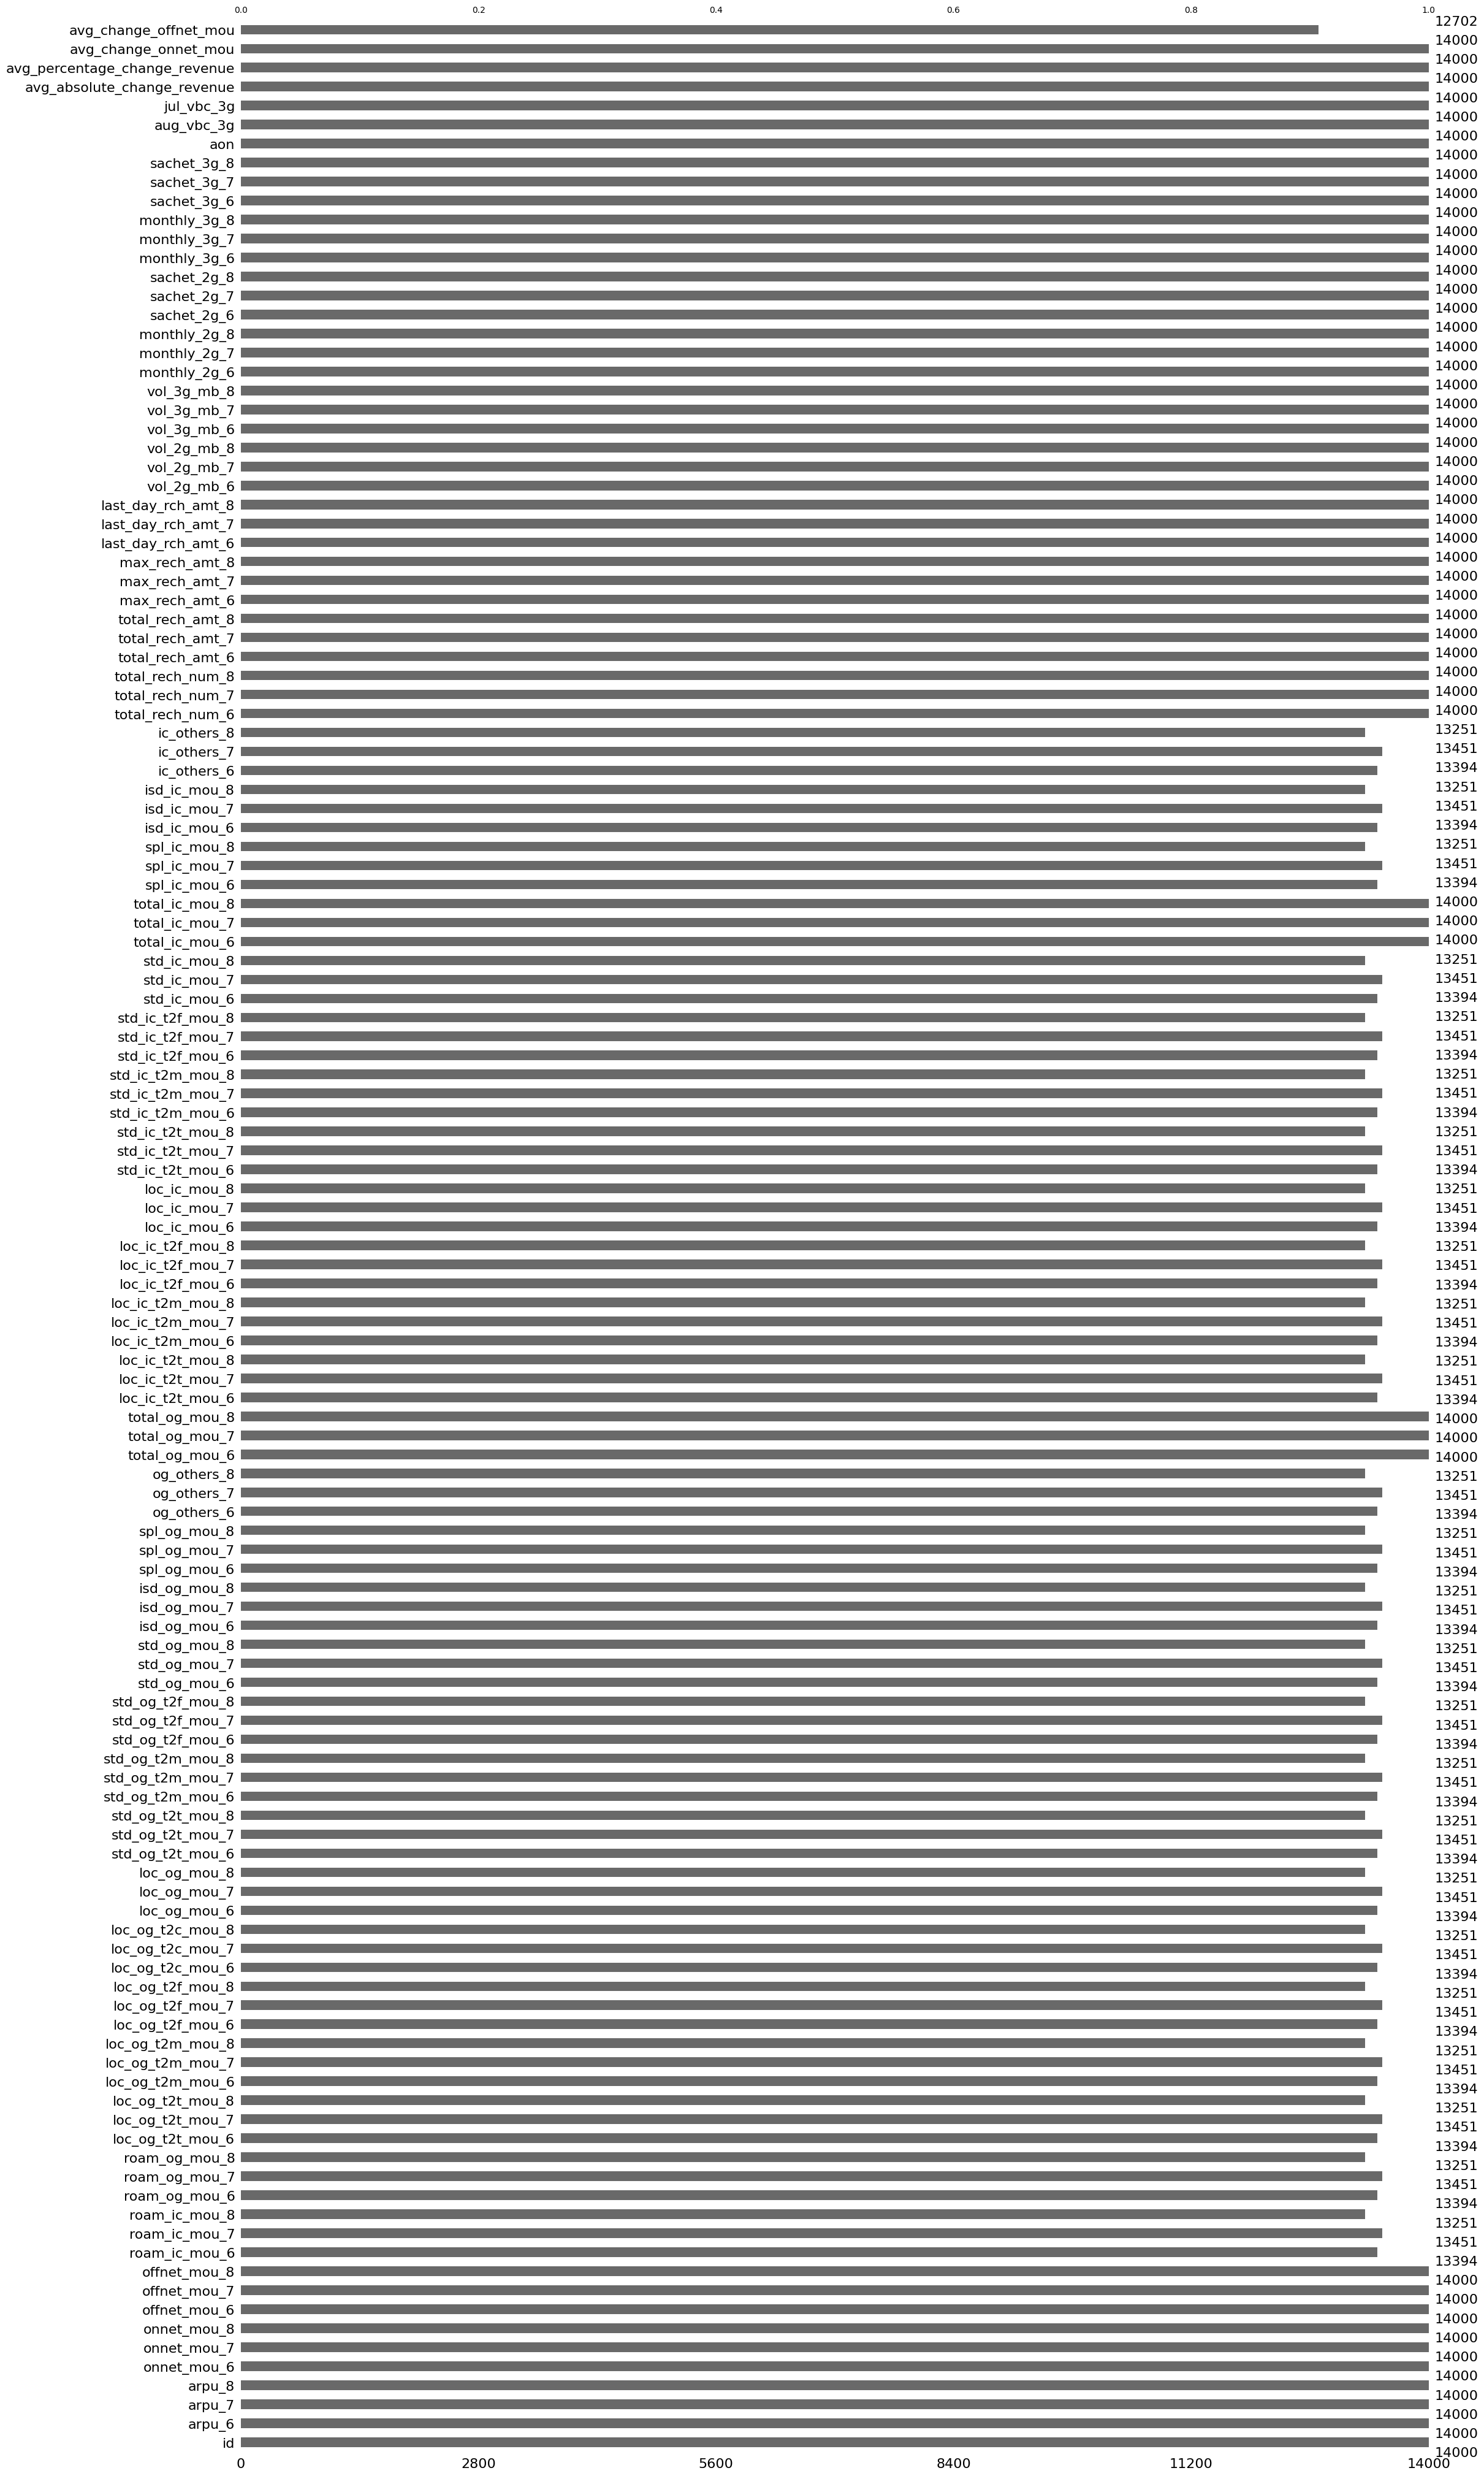

In [370]:
msno.bar(X_test)

In [371]:
missing_data_percent = X_test_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_

In [373]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_test_filtered[impute_cols] = imp.fit_transform(X_test_filtered[impute_cols])
unseen_filtered[impute_cols] = imp.fit_transform(unseen_filtered[impute_cols])


<Axes: >

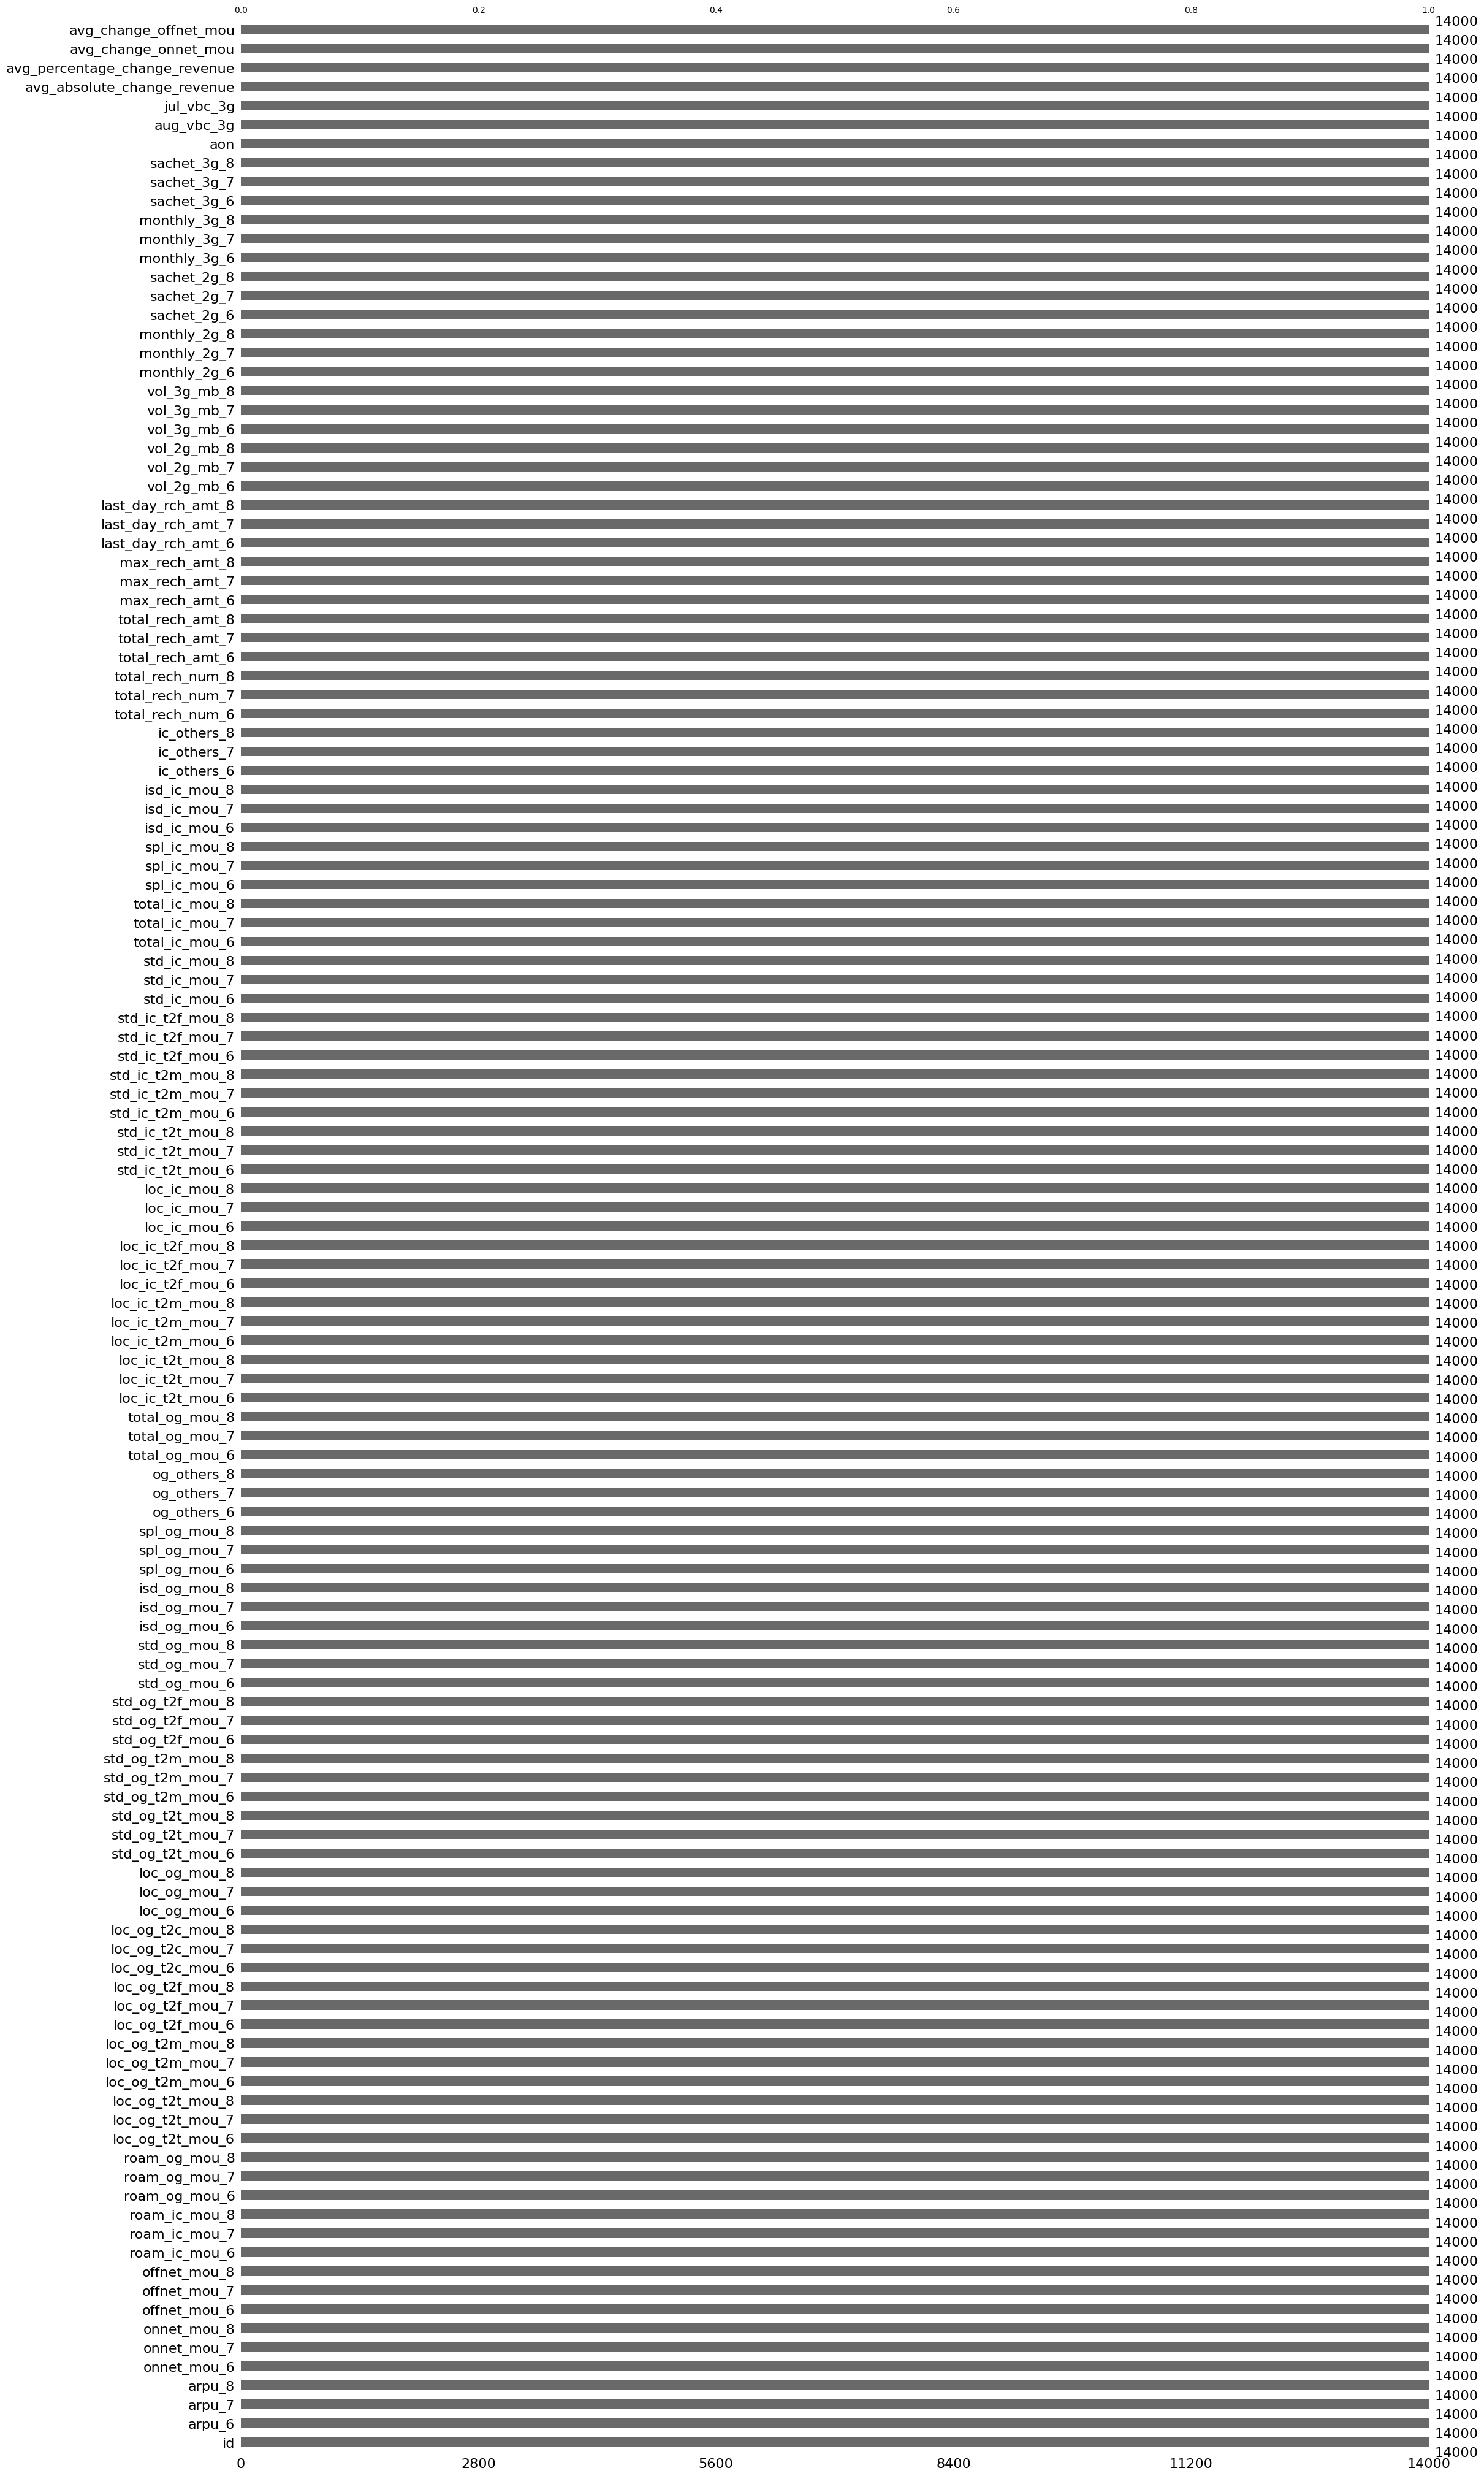

In [374]:
# Visually inspect X_test_filtered to check that missing values have been filled
msno.bar(X_test_filtered)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

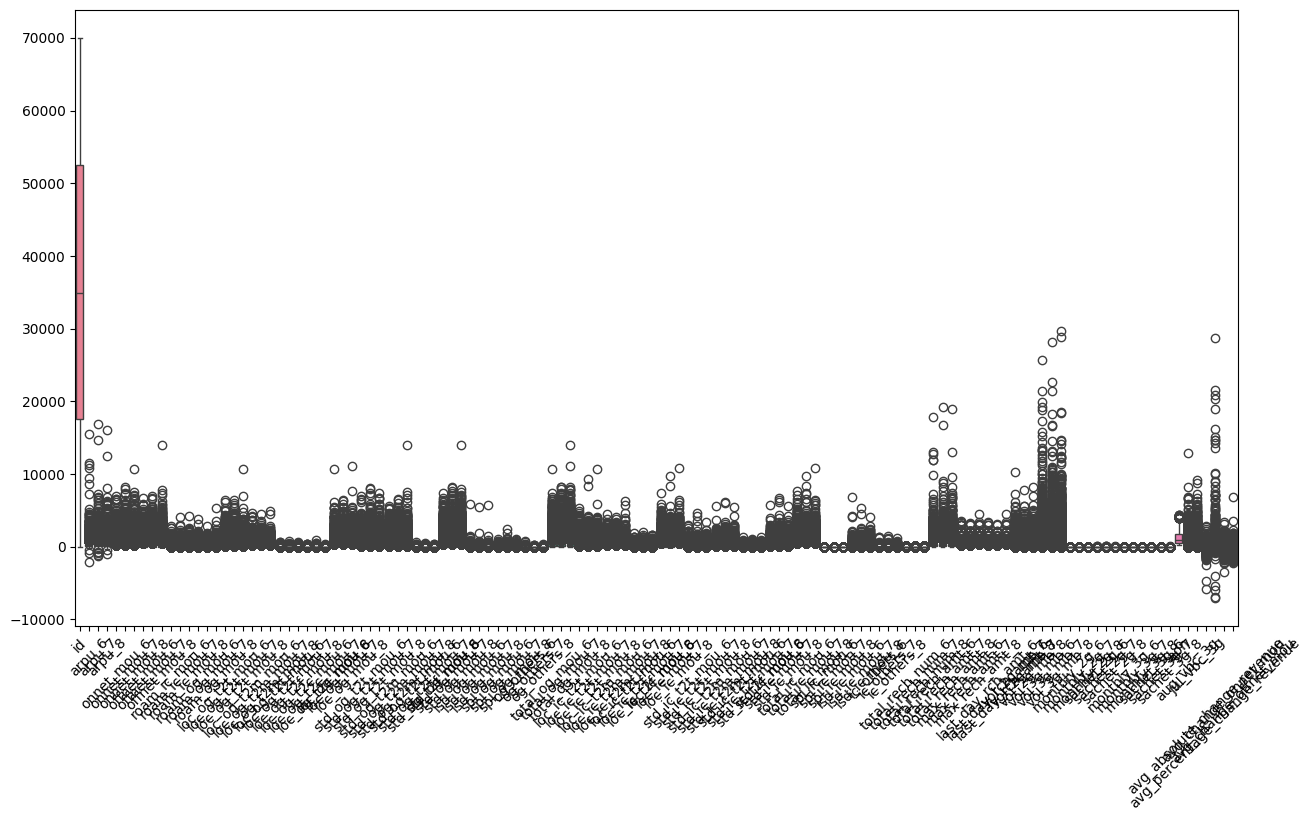

In [375]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

In [376]:
# From this graph it is possible to see that there are a significant amount of columns with outliers that need to be standardised later in this section
# We will now look at some of the key variables

### Analysing changes in average revenue per user

In [377]:
# Average revenue per user can help to identify high-value customers 

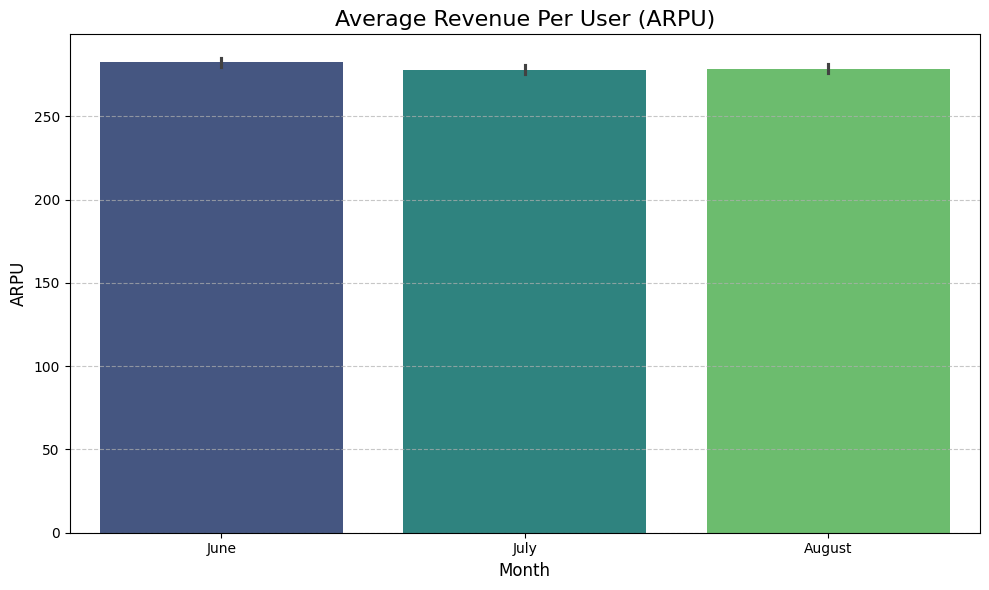

In [378]:
# Visualising Average Revenue per user
# Columns for ARPU
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
arpu_data = X_train_filtered[arpu_cols].copy()
arpu_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
arpu_long = arpu_data.melt(var_name='Month', value_name='ARPU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=arpu_long, x='Month', y='ARPU', palette='viridis')

# Customize the plot
plt.title('Average Revenue Per User (ARPU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('ARPU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()





In [379]:
# It appears that average revenue per customer is relatively stable month on month

### Visualising total outgoing minutes of usage

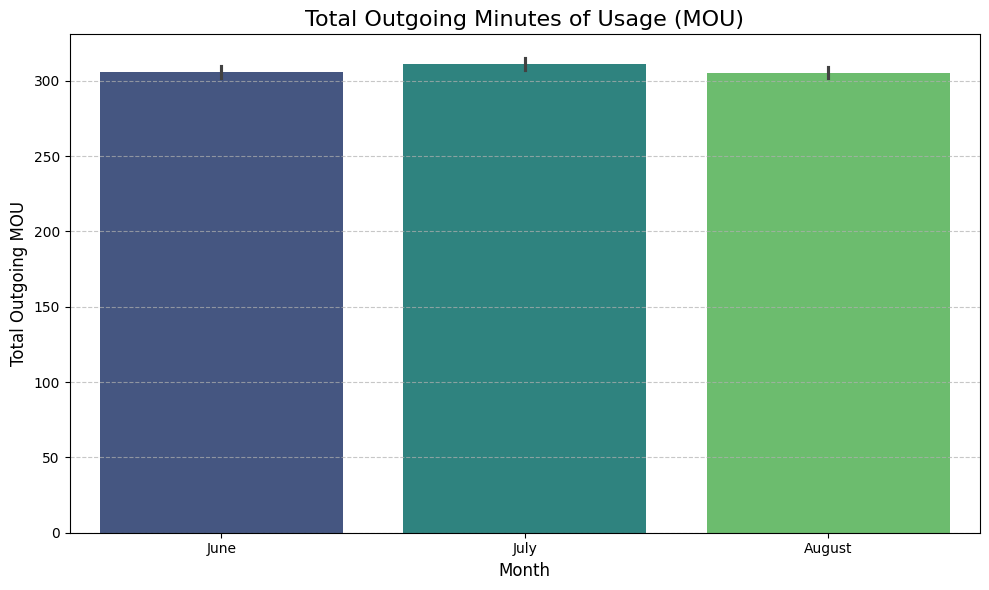

In [380]:
# Columns for total outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
mou_data = X_train_filtered[total_og_mou_cols].copy()
mou_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
mou_long = mou_data.melt(var_name='Month', value_name='Total Outgoing MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=mou_long, x='Month', y='Total Outgoing MOU', palette='viridis')

# Customize the plot
plt.title('Total Outgoing Minutes of Usage (MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Outgoing MOU', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Outgoing minutes of usage appears relatively stable

### Visualizing calls made outside the operator network

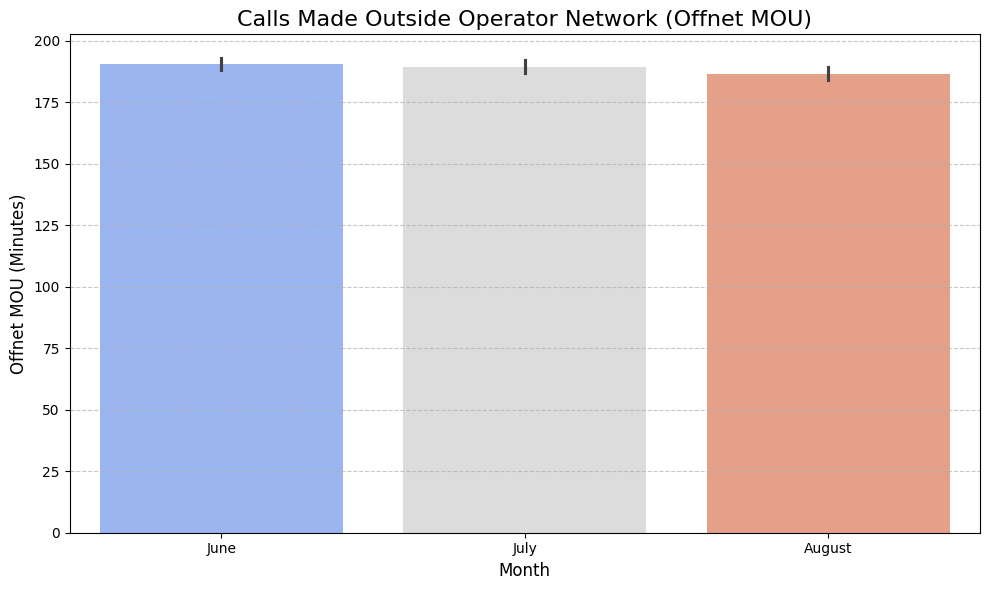

In [381]:
# Columns for calls made outside the operator network
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
months = ['June', 'July', 'August']

# Prepare the DataFrame for plotting
offnet_data = X_train_filtered[offnet_mou_cols].copy()
offnet_data.columns = months  # Rename columns for months

# Melt the DataFrame to long format
offnet_long = offnet_data.melt(var_name='Month', value_name='Offnet MOU')

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=offnet_long, x='Month', y='Offnet MOU', palette='coolwarm')

# Customize the plot
plt.title('Calls Made Outside Operator Network (Offnet MOU)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Offnet MOU (Minutes)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [382]:
# calls made outside the operator network appear relatively stable

### 4.3 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [383]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

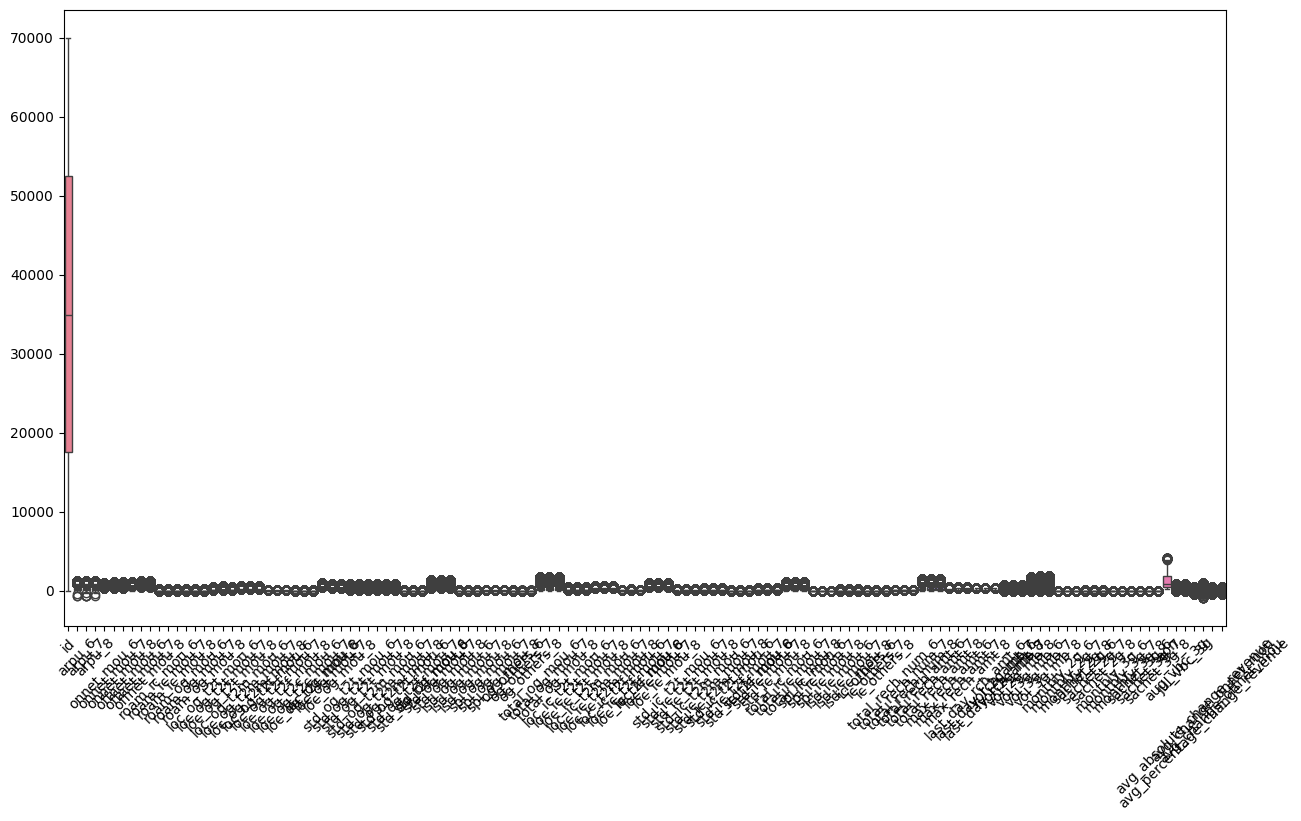

In [384]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.4 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [385]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [386]:
X_train_filtered1.head()

id   arpu_6       arpu_7       arpu_8  onnet_mou_6  onnet_mou_7  \
19615  19615  287.801   290.261000   191.137000    69.090000    85.960000   
5083    5083  647.859  1246.620322  1249.676909  1014.544099  1060.328454   
9411    9411   10.130     0.000000   261.281000     0.000000     0.000000   
44946  44946  313.487   319.496000   353.706000    14.910000     4.710000   
54857  54857  367.672   440.740000   445.746000   169.790000   419.980000   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
19615    41.660000        196.54        198.93        100.21  ...   
5083   1045.487428        297.86        723.71        522.58  ...   
9411    199.240000          1.08          0.00        168.09  ...   
44946    11.210000         39.99         75.29        137.13  ...   
54857   222.780000        182.79        156.01        414.58  ...   

       sachet_3g_6  sachet_3g_7  sachet_3g_8     aon  aug_vbc_3g  jul_vbc_3g  \
19615          0.0          0.0          0.0  1432.0        0.00        0.00   
5083           0.0          0.0          0.0  1243.0        0.00        0.00   
9411           0.0          0.0          0.0   515.0       65.09        0.00   
44946          0.0          0.0          0.0  1025.0      466.10      292.67   
54857          0.0          0.0          0.0   298.0        0.00        0.00   

       avg_absolute_change_revenue  avg_percentage_change_revenue  \
19615                     -48.3320                      -0.166476   
5083                      375.0435                       0.692707   
9411                      125.5755                       0.072072   
44946                      20.1095                       0.063122   
54857                      39.0370                       0.105045   

       avg_change_onnet_mou  avg_change_offnet_mou  
19615            -13.715000                -48.165  
5083             404.839941                112.360  
9411              99.620000                 83.505  
44946             -1.850000                 48.570  
54857             26.495000                115.895  

[5 rows x 128 columns]

<Axes: >

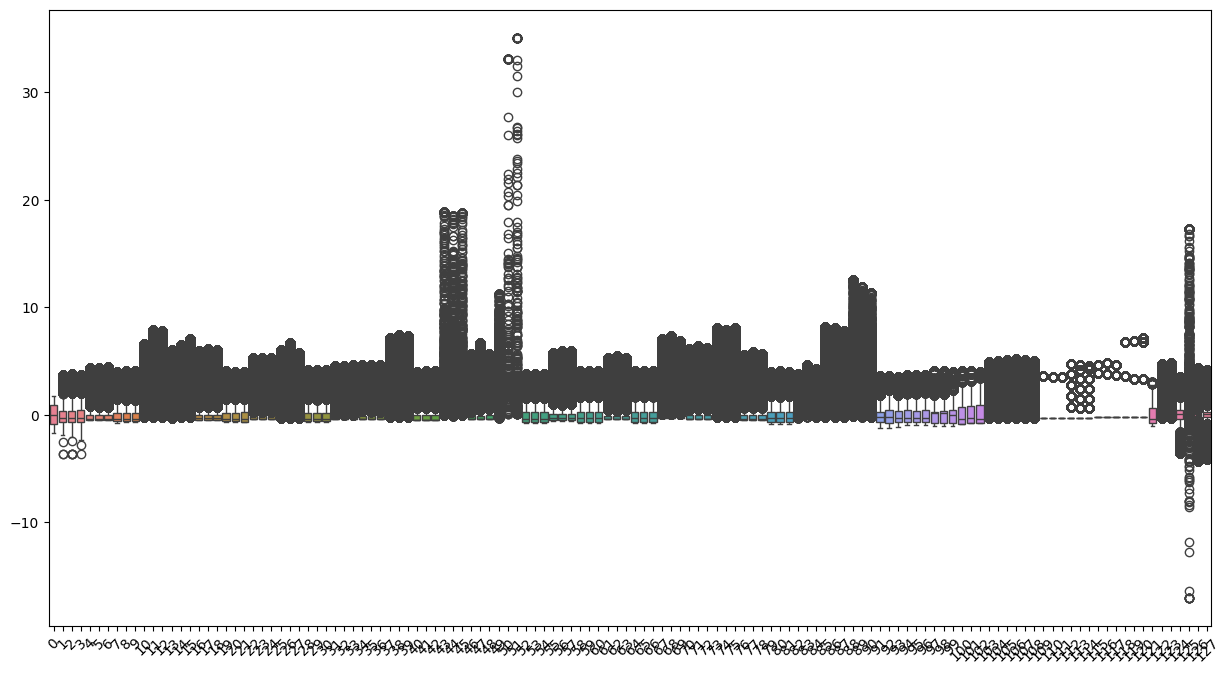

In [387]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2))

In [388]:
updated_cols = X_train_filtered.columns


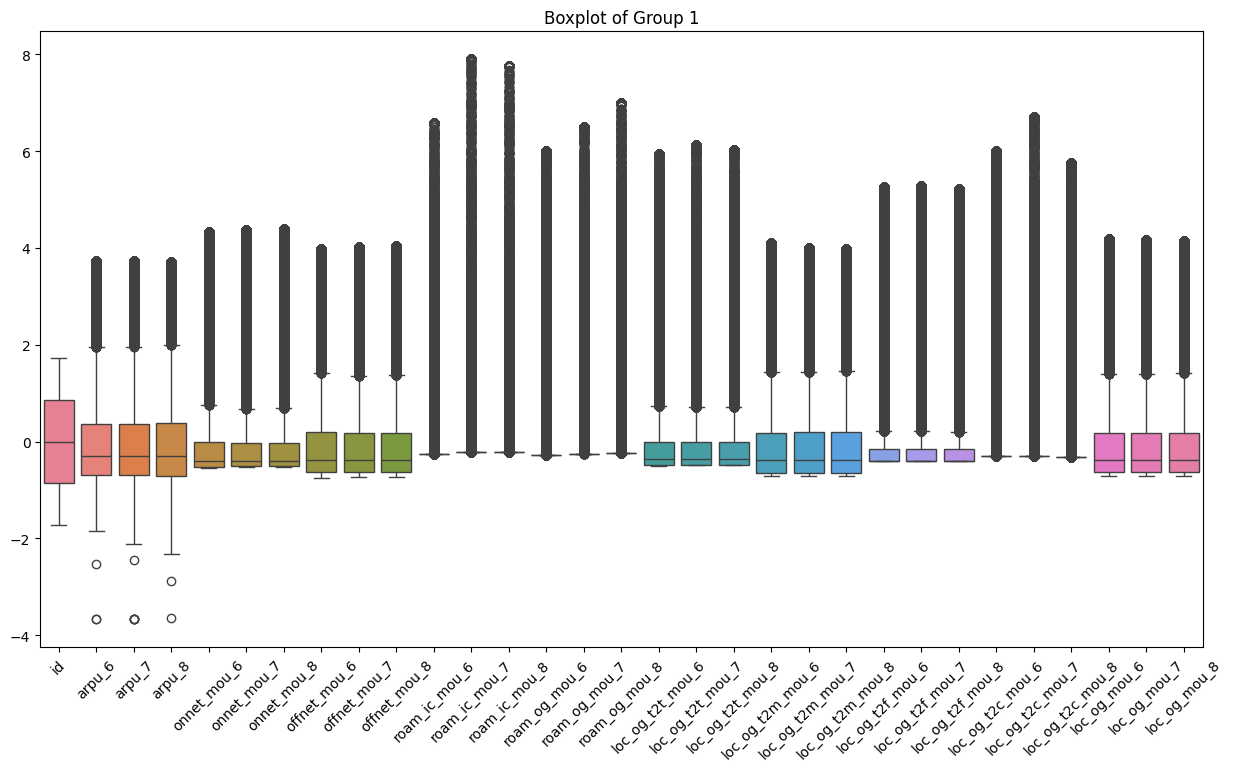

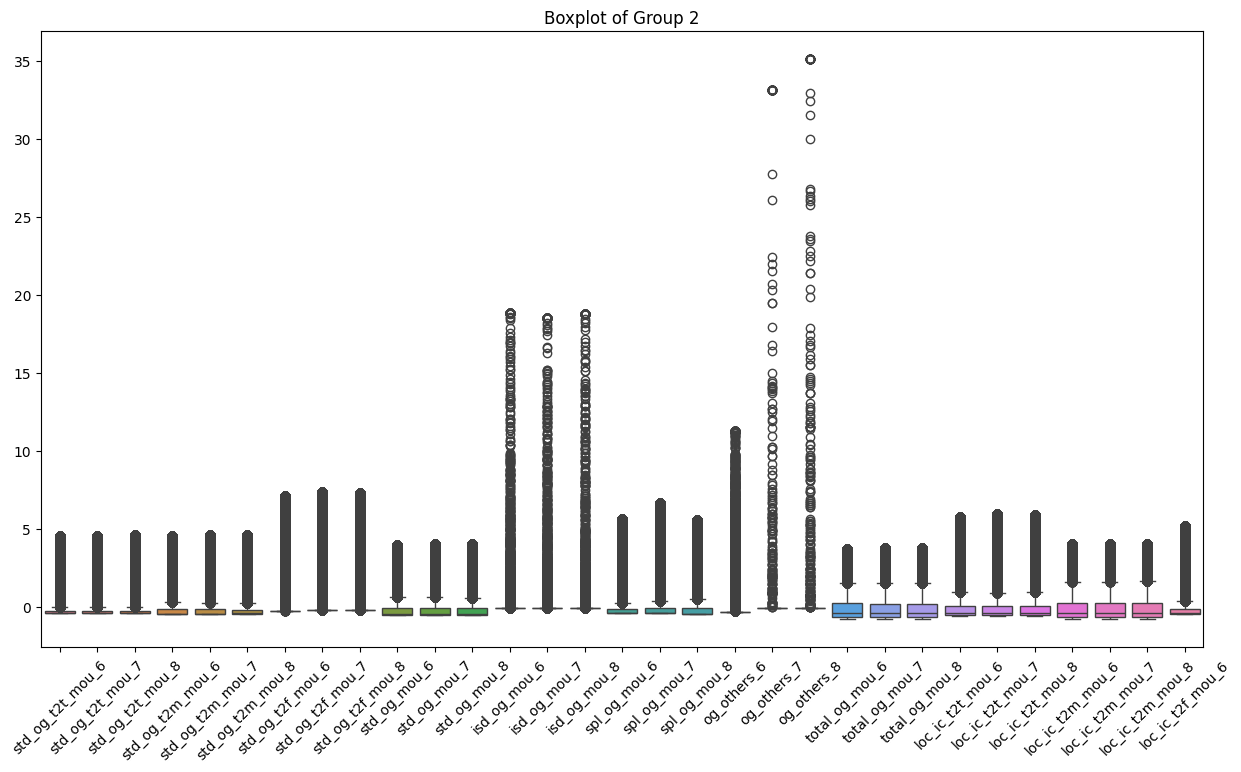

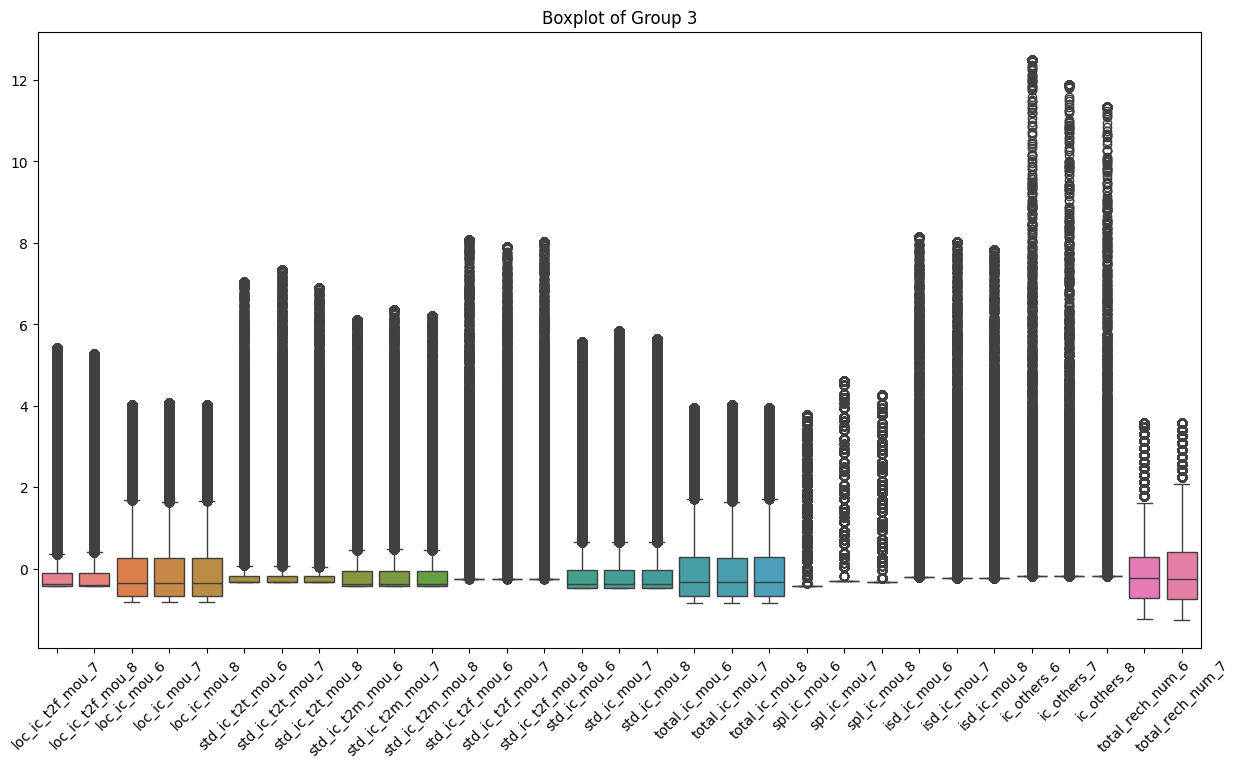

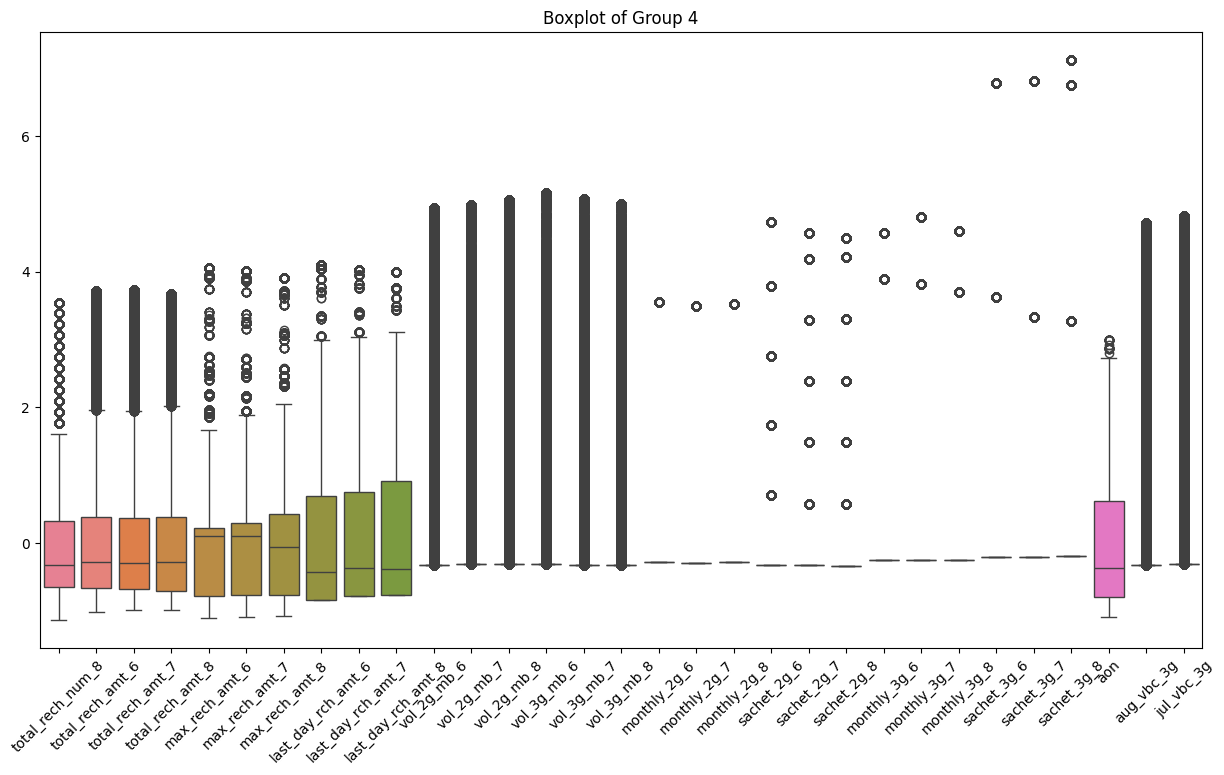

In [389]:
# Convert X_train_filtered2 to a DataFrame with column names from new_vars
X_train_filtered2_df = pd.DataFrame(X_train_filtered2, columns=updated_cols)

# Define the number of groups
num_groups = 4
columns_per_group = len(new_vars) // num_groups

# Create separate boxplots for each group of columns
for i in range(num_groups):
    # Select the subset of columns for this group
    start = i * columns_per_group
    end = (i + 1) * columns_per_group if i != num_groups - 1 else len(new_vars)
    group_columns = new_vars[start:end]
    
    # Create the boxplot for the current group by selecting only the relevant columns
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=45)
    sns.boxplot(data=X_train_filtered2_df[group_columns])
    plt.title(f"Boxplot of Group {i + 1}")
    plt.show()

### 4.5 Cross Correlation

<Axes: >

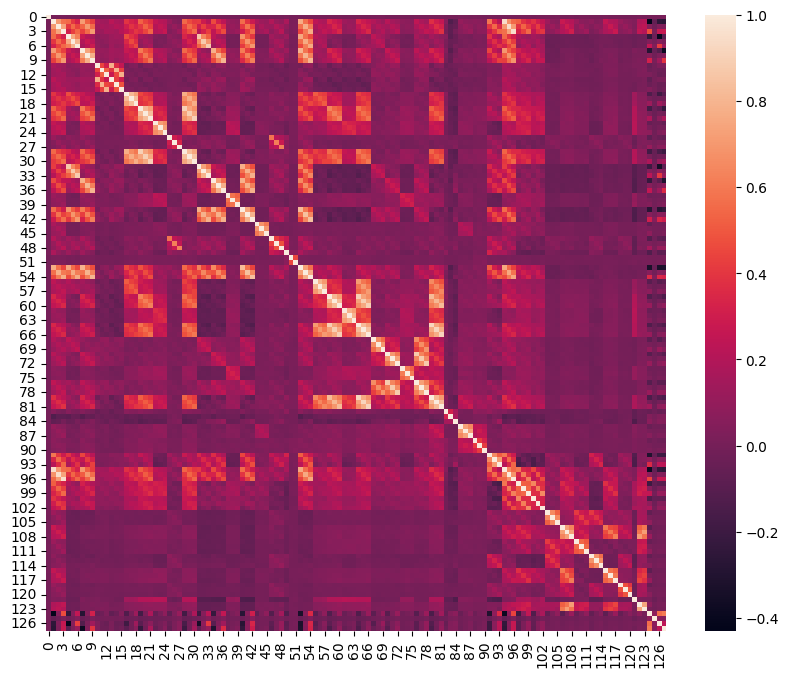

In [390]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2).corr())

In [391]:
# It appears that there is a range of correlation between the variables. This is less of an issue with PCA.

# 5. Creating Models

### Model 1. RFE with Logistic Regression 

#### Selecting Features with RFE

In [392]:
print(X_train_filtered2.shape)
print(y_train.shape)


(55999, 128)
(55999,)


In [393]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  # specify n_features_to_select as a keyword argument
rfe = rfe.fit(X_train_filtered2, y_train)
print(rfe.support_)  # Print the boolean results


[False False False False False False False  True False  True False False
 False False False False False False  True False False  True False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
  True False False  True False False  True False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False  True False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True]


In [394]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('id', False, 78),
 ('arpu_6', False, 48),
 ('arpu_7', False, 13),
 ('arpu_8', False, 19),
 ('onnet_mou_6', False, 50),
 ('onnet_mou_7', False, 68),
 ('onnet_mou_8', False, 100),
 ('offnet_mou_6', True, 1),
 ('offnet_mou_7', False, 104),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 116),
 ('roam_ic_mou_7', False, 55),
 ('roam_ic_mou_8', False, 94),
 ('roam_og_mou_6', False, 69),
 ('roam_og_mou_7', False, 113),
 ('roam_og_mou_8', False, 9),
 ('loc_og_t2t_mou_6', False, 36),
 ('loc_og_t2t_mou_7', False, 35),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 38),
 ('loc_og_t2m_mou_7', False, 115),
 ('loc_og_t2m_mou_8', True, 1),
 ('loc_og_t2f_mou_6', False, 54),
 ('loc_og_t2f_mou_7', False, 109),
 ('loc_og_t2f_mou_8', False, 90),
 ('loc_og_t2c_mou_6', False, 73),
 ('loc_og_t2c_mou_7', False, 81),
 ('loc_og_t2c_mou_8', False, 72),
 ('loc_og_mou_6', False, 37),
 ('loc_og_mou_7', False, 24),
 ('loc_og_mou_8', True, 1),
 ('std_og_t2t_mou_6', False, 53),
 ('std_og_t2t_mou_

In [395]:
col = X_train.columns[rfe.support_]

In [396]:
# Variables selected by RFE 
print(col)

Index(['offnet_mou_6', 'offnet_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'avg_change_offnet_mou'],
      dtype='object')


##### Assessing the model with StatsModels

In [397]:
# plt.figure(figsize=(10,8))
# sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

In [398]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_filtered2, y_train)

LogisticRegression(C=1000000000.0)

In [399]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
import statsmodels.api as sm
logm4 = sm.GLM(y_train,(sm.add_constant(X_train_filtered2)), family = sm.families.Binomial())
modres = logm4.fit()
logm4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                55999
Model:                            GLM   Df Residuals:                    55870
Model Family:                Binomial   Df Model:                          128
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11531.
Date:                Wed, 20 Nov 2024   Deviance:                       23063.
Time:                        06:56:00   Pearson chi2:                 2.21e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2145
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.1951      0.049    -86.304      0.000      -4.290      -4.100
x1             0.0282      0.017      1.663      0.096      -0.005       0.061
x2             0.0725      0.119      0.608      0.543      -0.161       0.306
x3             0.2596      0.075      3.478      0.001       0.113       0.406
x4             0.4671      0.136      3.423      0.001       0.200       0.734
x5            -0.2839      0.138     -2.058      0.040      -0.554      -0.014
x6             0.0953      0.140      0.683      0.495      -0.178       0.369
x7            -0.0842      0.170     -0.495      0.621      -0.418       0.250
x8             0.5602      0.130      4.313      0.000       0.306       0.815
x9            -0.0585      0.139     -0.421      0.674      -0.331       0.214
x10           -1.2346      0.160     -7.715      0.000      -1.548      -0.921
x11           -0.0003      0.027     -0.011      0.991      -0.054       0.053
x12            0.0501      0.027      1.887      0.059      -0.002       0.102
x13            0.0094      0.024      0.398      0.691      -0.037       0.056
x14            0.0465      0.031      1.498      0.134      -0.014       0.107
x15            0.0059      0.027      0.216      0.829      -0.048       0.059
x16            0.2217      0.027      8.144      0.000       0.168       0.275
x17           -0.1116      0.111     -1.003      0.316      -0.330       0.106
x18            0.2177      0.142      1.535      0.125      -0.060       0.496
x19           -0.7041      0.183     -3.852      0.000      -1.062      -0.346
x20           -0.2084      0.156     -1.339      0.181      -0.514       0.097
x21            0.2561      0.199      1.290      0.197      -0.133       0.645
x22           -0.9259      0.252     -3.673      0.000      -1.420      -0.432
x23           -0.0597      0.036     -1.668      0.095      -0.130       0.010
x24            0.0176      0.043      0.407      0.684      -0.067       0.102
x25           -0.0447      0.049     -0.917      0.359      -0.140       0.051
x26           -0.0426      0.023     -1.865      0.062      -0.087       0.002
x27            0.0176      0.025      0.699      0.485      -0.032       0.067
x28            0.0383      0.031      1.226      0.220      -0.023       0.100
x29            0.2973      0.251      1.186      0.236      -0.194       0.789
x30           -0.5290      0.313     -1.693      0.091      -1.142       0.084
x31            1.4178      0.383      3.705      0.000       0.668       2.168
x32            0.1558      0.109      1.426      0.154      -0.058       0.370
x33            0.0024      0.132      0.018      0.985      -0.256       0.261
x34           -0.1036      0.163     -0.637      0.524      -0.423       0.215
x35            0.1044      0.101      1.036      0.300      -0.093       0.302
x3

In [400]:
X_test.describe

<bound method NDFrame.describe of           id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
37953  37953  313.792  316.683  339.438        61.58        42.83   
23868  23868  121.201  114.800  105.200       216.36       171.38   
59023  59023  309.744  361.833  292.150        55.53        90.04   
20000  20000  163.561  302.816  305.618         8.51         3.59   
33859  33859  604.630  508.980  494.525      1033.16       904.13   
...      ...      ...      ...      ...          ...          ...   
61639  61639  333.414  231.148  546.690        64.01        45.93   
19302  19302  308.379  316.184  323.415        36.61        27.18   
48827  48827  746.940  254.573  352.289         0.55         1.04   
49577  49577  155.861  242.652  457.586         1.00         0.00   
44285  44285  361.206  574.009  380.966       165.84        90.09   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  \
37953        66.88         90.68         75.83         68.29  ...   

In [401]:
# X_test[col].shape
# #res = modres.predict(X_test[col])

### Making Predictions with RFE

In [402]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_test_filtered)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

1
0  1.0
1  1.0
2  1.0
3  1.0
4  1.0

In [403]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn_probability
37953                  0
23868                  0
59023                  0
20000                  0
33859                  0

In [404]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns using reindex
y_pred_final = y_pred_final.reindex(columns=['CustID', 'churn_probability', 'Churn_Prob'])

# Let's see the head of y_pred_final
y_pred_final.head()


CustID  churn_probability  Churn_Prob
0   37953                  0         1.0
1   23868                  0         1.0
2   59023                  0         1.0
3   20000                  0         1.0
4   33859                  0         1.0

In [405]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

CustID  churn_probability  Churn_Prob  predicted
0   37953                  0         1.0          1
1   23868                  0         1.0          1
2   59023                  0         1.0          1
3   20000                  0         1.0          1
4   33859                  0         1.0          1

### RFE Model Evaluation

In [406]:
from sklearn import metrics

In [407]:
print(y_pred_final.isnull().sum())


CustID               0
churn_probability    0
Churn_Prob           0
predicted            0
dtype: int64


In [408]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn_probability , y_pred_final.predicted )
confusion

array([[3216, 9291],
       [ 181, 1312]])

In [409]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn_probability, y_pred_final.predicted)

0.32342857142857145

In [410]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_pred_final['churn_probability'], y_pred_final['predicted'])
recall = recall_score(y_pred_final['churn_probability'], y_pred_final['predicted'])
f1 = f1_score(y_pred_final['churn_probability'], y_pred_final['predicted'])

print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Precision: 0.1237
Recall (Sensitivity): 0.8788
F1-Score: 0.2169


### Model 2. Logistic Regression and PCA 

In [411]:


# converting to data frame, in order to extract columns
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)


In [412]:
from sklearn.decomposition import PCA

<Axes: >

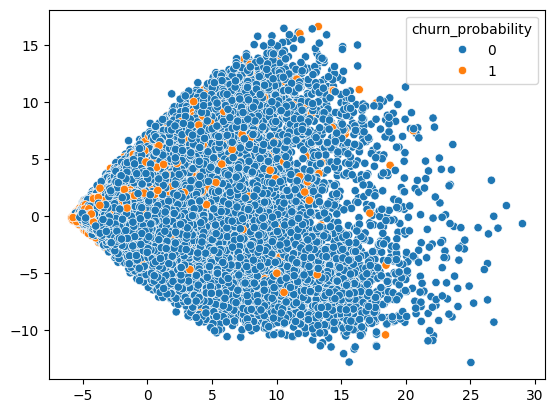

In [413]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

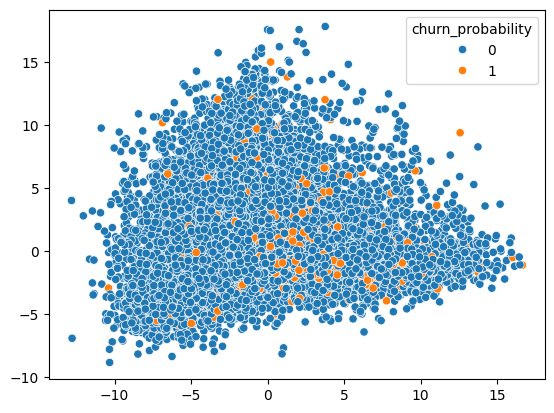

In [414]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

#### Feature engineering and selection

<BarContainer object of 128 artists>

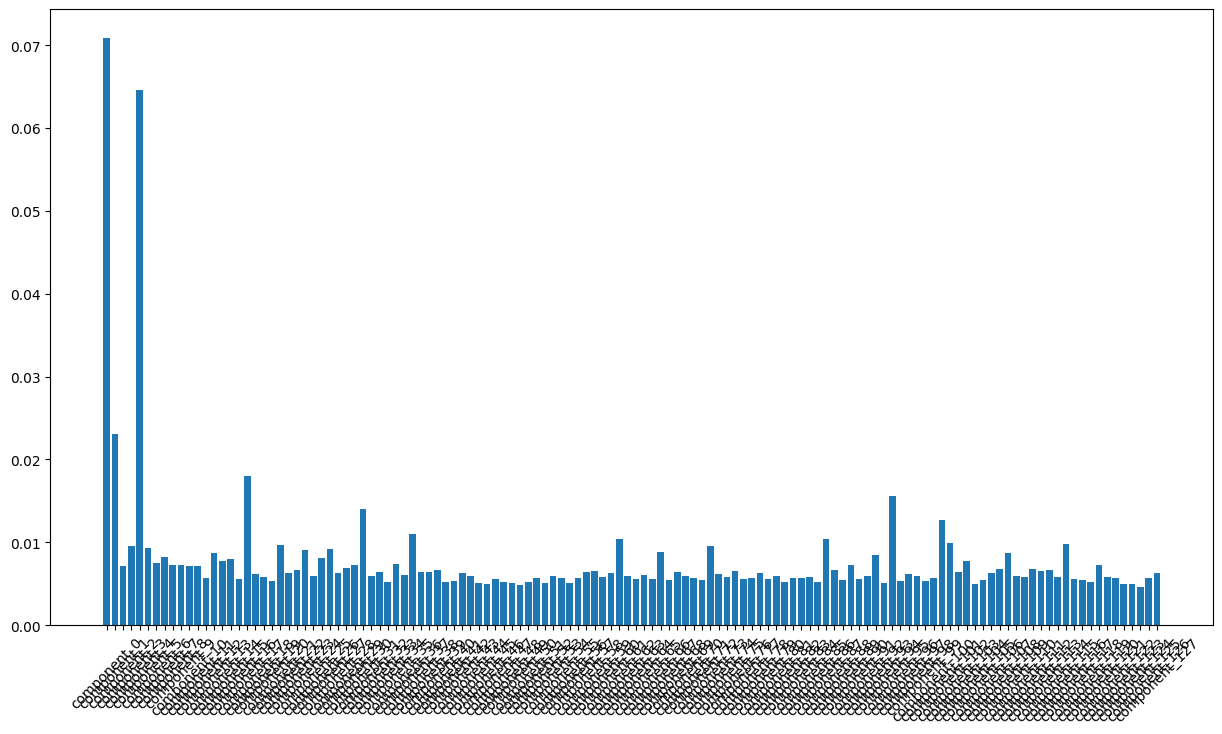

In [415]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({
    'col': ['component_' + str(i) for i in range(len(rf.feature_importances_))],
    'importance': rf.feature_importances_
})


plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

#### Adding Logistic Regression Model

In [416]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [417]:
lr.score(pca_components[:,:2], y_train)

0.8993017732459508

In [418]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [419]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [420]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [421]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8979981785389025


In [422]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8919285714285714


In [423]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50147,   213],
       [ 5499,   140]])

In [424]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12442,    65],
       [ 1448,    45]])

In [425]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.4090909090909091

In [426]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.03014065639651708

### Model 3. SMOTE, Logistic Regression and PCA 

<Axes: xlabel='churn_probability', ylabel='Count'>

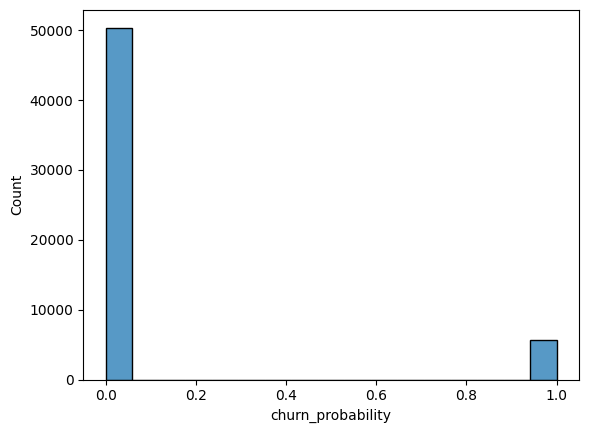

In [427]:
#Distribution for the churn probability
sns.histplot(y_train)

In [428]:
print("Shape of X_train_filtered2:", X_train_filtered2.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_filtered2: (55999, 128)
Shape of y_train: (55999,)


In [429]:
from imblearn.over_sampling import SMOTE

In [430]:
smt = SMOTE(random_state=2)
X_train_filtered2_smote, y_train_smote = smt.fit_resample(X_train_filtered2, y_train)

<Axes: xlabel='churn_probability', ylabel='Count'>

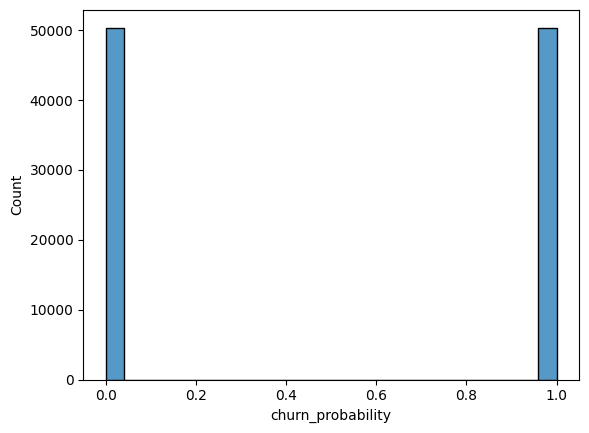

In [431]:
#Distribution for the churn probability
sns.histplot(y_train_smote)

### PCA on smote values

<Axes: >

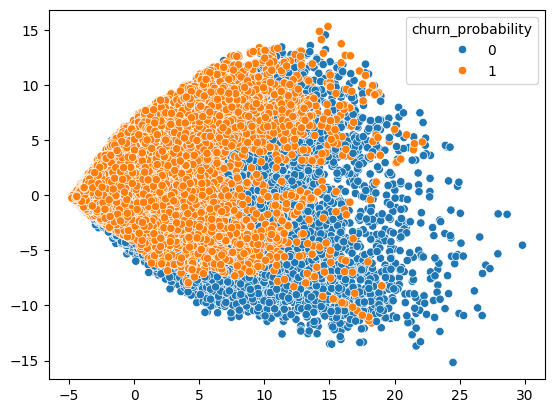

In [432]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2_smote)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_smote)

<Axes: >

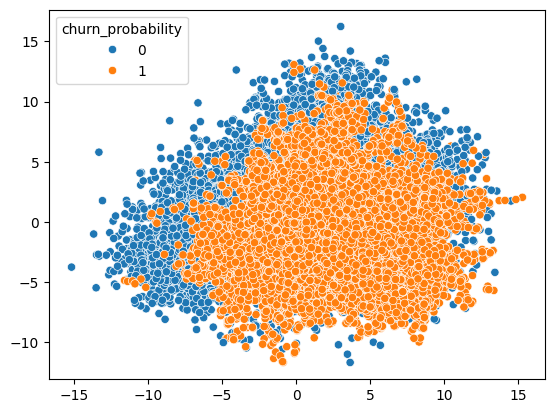

In [433]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train_smote)

<BarContainer object of 128 artists>

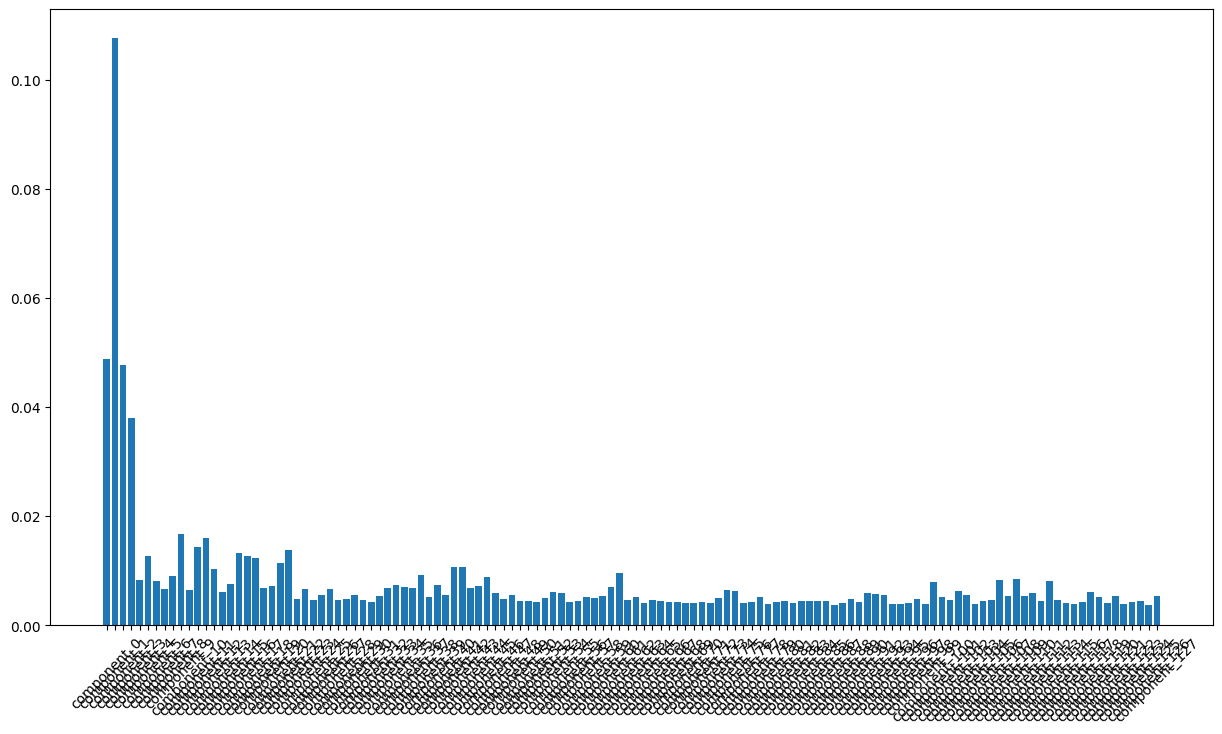

In [434]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train_smote)

feature_importances = pd.DataFrame({
    'col': ['component_' + str(i) for i in range(len(rf.feature_importances_))],
    'importance': rf.feature_importances_
})


plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

#### Adding Logistic Regression Model

In [435]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [436]:
lr.score(pca_components[:,:2], y_train_smote)

0.7414912629070691

### Model 4. PCA, SMOTE and GridSearchCV

In [437]:
from sklearn.tree import DecisionTreeClassifier

# Create and fit the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filtered2, y_train)

dt = DecisionTreeClassifier(random_state=42)

In [438]:
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaler = StandardScaler()
pca = PCA(n_components=25)
smote = SMOTE(random_state=2)

In [439]:
from imblearn.pipeline import make_pipeline
# Create a pipeline
pipe = make_pipeline(
    imputer,
    smote,
    scaler,
    pca,
    dt
)

In [440]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100],
}

In [441]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [442]:

# Fit the GridSearchCV
grid_search.fit(X_train_filtered2, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(fill_value=0,
                                                      strategy='constant')),
                                       ('smote', SMOTE(random_state=2)),
                                       ('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=25)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [443]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Predict on train set using the best model
y_train_pred = grid_search.predict(X_train_filtered2)

# Predict on validation set using the best model
y_val_pred = grid_search.predict(X_test)

In [444]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
# Confusion Matrix
cm = confusion_matrix(y_train, y_train_pred)
print("Confusion Matrix:\n")
print(cm)

# Extract TP, FP, TN, FN from the confusion matrix
TP = cm[1, 1]
FP = cm[0, 1]
TN = cm[0, 0]
FN = cm[1, 0]

Confusion Matrix:

[[43051  7309]
 [ 1013  4626]]


In [445]:


# Classification Metrics
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)  # Same as sensitivity
f1 = f1_score(y_train, y_train_pred)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity manually calculated
false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nClassification Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")


Classification Metrics:
Accuracy: 0.8514
Precision: 0.3876
Recall (Sensitivity): 0.8204
Specificity: 0.8549
F1 Score: 0.5265
False Positive Rate: 0.1451


# 6 Technical Synopsis: Model Selection for Telecom Churn Prediction

This case study explores various machine learning models for predicting telecom churn, with a focus on identifying the most effective model based on sensitivity. The models tested include:

1. Logistic Regression (LR) with Recursive Feature Elimination (RFE)
2. Logistic Regression (LR) with hyperparameter tuning
3. Principal Component Analysis (PCA) applied to various classifiers
4. Decision Tree, Random Forest classifiers with hyperparameter tuning and PCA

Key findings from the experimentation include:

- Logistic Regression with PCA consistently demonstrated the highest sensitivity in both the training and validation sets, outperforming other models.
- Other models, despite showing promising accuracy during training, exhibited signs of **overfitting** with poor performance on the test set.

Given the business context of telecom churn, where minimizing false negatives (churned customers) is critical, **sensitivity** is prioritized as the key performance metric. Therefore, **Logistic Regression with PCA** is determined to be the most suitable model for predicting telecom churn, providing the best balance of model performance and interpretability.

### Conclusion:
Logistic Regression with PCA is recommended as the final model for churn prediction due to its superior sensitivity in both the training and validation phases, making it the optimal choice for minimizing churn in a telecom context.

# 7. Creating Submission File


In [446]:
unseen_filtered.describe()

id        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count  14000.000000  14000.000000  14000.000000  14000.000000  14000.000000   
mean   35036.103071    285.136801    278.790671    279.742721    129.120535   
std    20237.507168    383.546573    419.516179    447.426033    292.955771   
min        8.000000  -2258.709000  -1077.191000    -75.769000      0.000000   
25%    17369.250000     92.506750     85.224500     84.049250      5.287500   
50%    35112.500000    199.150500    192.664000    190.629500     30.985000   
75%    52601.250000    371.709500    367.193250    368.001250    114.500000   
max    69993.000000  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  14000.000000  14000.000000  14000.000000  14000.000000  14000.000000   
mean     126.186899    123.737799    193.385991    190.476539    184.735168   
std      289.838960    299.570403    319.224494    317.081402    312.577887   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.730000      3.930000     28.705000     26.630000     23.725000   
50%       29.760000     28.325000     90.645000     86.220000     83.970000   
75%      112.645000    106.465000    224.812500    217.877500    217.180000   
max     7741.530000   9977.410000   8362.360000   5887.140000   5453.330000   

       ...   sachet_3g_6   sachet_3g_7   sachet_3g_8           aon  \
count  ...  14000.000000  14000.000000  14000.000000  14000.000000   
mean   ...      0.068071      0.077643      0.087286   1217.262643   
std    ...      0.532944      0.640703      0.706694    950.365384   
min    ...      0.000000      0.000000      0.000000    180.000000   
25%    ...      0.000000      0.000000      0.000000    466.000000   
50%    ...      0.000000      0.000000      0.000000    867.000000   
75%    ...      0.000000      0.000000      0.000000   1811.500000   
max    ...     23.000000     24.000000     41.000000   4319.000000   

         aug_vbc_3g    jul_vbc_3g  avg_absolute_change_revenue  \
count  14000.000000  14000.000000                 14000.000000   
mean      71.215234     65.211972                    -2.697040   
std      282.383499    259.089217                   157.021786   
min        0.000000      0.000000                 -2408.609500   
25%        0.000000      0.000000                   -52.935375   
50%        0.000000      0.000000                    -1.142250   
75%        0.000000      0.000000                    48.521625   
max     8476.260000   5141.740000                  6804.332000   

       avg_percentage_change_revenue  avg_change_onnet_mou  \
count                   14000.000000          14000.000000   
mean                       11.760899             -2.691368   
std                       316.329671            134.336526   
min                      -709.574889          -2475.845000   
25%                        -0.138719            -12.850000   
50%                         0.072072              0.000000   
75%                         0.389062             10.650000   
max                     30174.501095           3395.190000   

       avg_change_offnet_mou  
count           14000.000000  
mean               -2.642607  
std               142.480814  
min             -4166.000000  
25%               -23.117500  
50%                 0.000000  
75%                19.711250  
max              2393.090000  

[8 rows x 128 columns]

In [449]:
submission_data = unseen_filtered.set_index('id')
submission_data.shape

(14000, 127)

In [450]:
unseen_filtered['churn_probability'] = pipe.predict(submission_data)
output = unseen_filtered[['id','churn_probability']]
output.head()

NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
output.to_csv('submission_pca_lr_20nov.csv',index=False)